# EVI, Nighttime Lights, and GDP Analysis

## Library

In [1]:
import pandas as pd

from pathlib import Path

import pandas as pd
import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import shap
import numpy as np

import warnings

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
EVI_PATH = DATA_PATH / "EVI and Crop Land" / "EVI 2010-2025"
CROPLAND_PATH = DATA_PATH / "EVI and Crop Land" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Functions

In [2]:
def preprocess_evi(evi_file: str | Path) -> pd.DataFrame:
    """Preprocess EVI CSV file."""
    evi_df = pd.read_csv(evi_file)

    metadata_cols = [
        col for col in evi_df.columns if "EVI" not in col and "system:index" not in col
    ]
    evi_df = (
        evi_df.rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
        .drop(columns=["system:index"])
        .melt(
            id_vars=metadata_cols,
            var_name="band_date",
            value_name="EVI",
        )
        .assign(
            date=lambda df: pd.to_datetime(
                df["band_date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0],
                format="%Y_%m_%d",
            ),
        )
    )
    return evi_df


def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def format_currency_labels(l: list[float]) -> list[str]:
    """Format currency labels by shortening large numbers with K, M, B suffixes."""
    labels = []
    for v in l:
        if v >= 1_000_000_000:
            labels.append("{:.1f}B".format(v / 1_000_000_000))
        elif v >= 1_000_000:
            labels.append("{:.1f}M".format(v / 1_000_000))
        elif v >= 1_000:
            labels.append("{:.1f}K".format(v / 1_000))
        else:
            labels.append(str(v))
    return labels

## Data

This analysis utilizes the following datasets:

* Overall GDP Data: Sourced from the World Bank World Development Indicators (WDI) database
* Sectoral GDP Data: Provided by the Myanmar team
* Enhanced Vegetation Index (EVI) Data: Derived from MODIS satellite imagery

In [3]:
gdp_overall = (
    (
        pd.read_csv(DATA_PATH / "GDP" / "GDP All Countries.csv", skiprows=4)
        .pipe(clean_names)
        .loc[lambda df: df["country_name"] == "Myanmar"]
    )
    .melt(
        id_vars=["country_name", "country_code", "indicator_name", "indicator_code"],
        var_name="year",
        value_name="gdp_overall",
    )
    .dropna(subset=["gdp_overall"])
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        gdp_overall=lambda df: df["gdp_overall"] / 1_000_000,
    )
    .set_index("date")
)

In [4]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

evi_adm0_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 0"
                / "MIMU"
                / f"myanmar_adm0_evi_stats_{year}.csv"
            )
            for year in range(2010, 2026)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["date"])
    .reset_index(drop=True)
    .set_index("date")
)
evi_adm1_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 1"
                / "MIMU"
                / f"myanmar_adm1_evi_stats_{year}_batch{batch}.csv"
            )
            for year in range(2010, 2026)
            for batch in range(1, 4)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["ST", "date"])
    .reset_index(drop=True)
    .rename(columns={"ST": "adm1_name"})
    .set_index("date")
)

evi_adm0 = (
    evi_adm0_raw.groupby(pd.Grouper(freq="QS")).agg({"EVI": "median"}).pipe(clean_names)
)

evi_adm1 = (
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"EVI": "median"})
    .pipe(clean_names)
)

In [5]:
ntl_adm0_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)
ntl_adm1_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)

ntl_adm0 = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(-1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(-2),
    )
)

ntl_adm1 = (
    ntl_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

In [6]:
no2_adm3_raw = pd.read_csv(DATA_PATH / "AirPollution" / "myanmar_no2_adm3.csv").rename(
    columns={"start_date": "date"}
)
no2_industrial_raw = pd.read_csv(
    DATA_PATH / "AirPollution" / "myanmar_no2_industrial_zones.csv"
)

no2_adm3 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm3_en": "adm3_name"})
    .groupby(["adm3_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm1 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm0 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

In [7]:
adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "agriculture": [df_bago["agriculture"].values[0] / 2] * 2,
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "agriculture": [df_shan["agriculture"].values[0] / 3] * 3,
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(
        agriculture_pct=lambda df: df["agriculture"] / df["agriculture"].sum(),
        industry_pct=lambda df: df["industry"] / df["industry"].sum(),
        services_pct=lambda df: df["services"] / df["services"].sum(),
    )
)

gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    # For Agriculture, keep only rows where economic_activity is also Agriculture
    .query('not (sub_group == "Agriculture" and economic_activity != "Agriculture")')
    .set_index("date")
    .groupby(["sub_group", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
)


# gdp_quarterly = (
#     gdp_quarterly_raw.pipe(clean_names)
#     .melt(
#         id_vars=["quarter", "sub_group", "economic_activity"],
#         var_name="year",
#         value_name="gdp",
#     )
#     .assign(
#         quarter_clean=lambda df: df["quarter"].str.strip(),
#         year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
#         year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
#         year_selected=lambda df: df.apply(
#             lambda row: row["year_last"]
#             if row["quarter_clean"] in ["Q1", "Q2"]
#             else row["year_first"],
#             axis=1,
#         ),
#         date=lambda df: pd.to_datetime(df["year_selected"] + df["quarter_clean"]),
#         sub_group=lambda df: df["sub_group"].str.strip(),
#         economic_activity=lambda df: df["economic_activity"].str.strip(),
#     )
#     # For Agriculture, keep only rows where economic_activity is also Agriculture
#     .query('not (sub_group == "Agriculture" and economic_activity != "Agriculture")')
#     .set_index("date")
#     .groupby(["sub_group", pd.Grouper(freq="QS")])
#     .agg({"gdp": "sum"})
# )

gdp_agri_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .query('sub_group == "Agriculture" & economic_activity == "Agriculture"')
    .rename(columns={"gdp": "gdp_agri"})
    .filter(["gdp_agri"])
)

# gdp_agri_quarterly = (
#     gdp_quarterly_raw.pipe(clean_names)
#     .melt(
#         id_vars=["quarter", "sub_group", "economic_activity"],
#         var_name="year",
#         value_name="gdp",
#     )
#     .assign(
#         quarter_clean=lambda df: df["quarter"].str.strip(),
#         year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
#         year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
#         year_selected=lambda df: df.apply(
#             lambda row: row["year_last"]
#             if row["quarter_clean"] in ["Q1", "Q2"]
#             else row["year_first"],
#             axis=1,
#         ),
#         date=lambda df: pd.to_datetime(df["year_selected"] + df["quarter_clean"]),
#         sub_group=lambda df: df["sub_group"].str.strip(),
#         economic_activity=lambda df: df["economic_activity"].str.strip(),
#     )
#     .set_index("date")
#     .sort_index()
#     .query('sub_group == "Agriculture" & economic_activity == "Agriculture"')
#     .rename(columns={"gdp": "gdp_agri"})
#     .filter(["gdp_agri"])
# )

gdp_mft_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .query('sub_group == "Industry"')
    .groupby(pd.Grouper(freq="QS"))
    .agg({"gdp": "sum"})
    .rename(columns={"gdp": "gdp_mft"})
    .filter(["gdp_mft"])
)

gdp_svc_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .query('sub_group == "Services"')
    .groupby(pd.Grouper(freq="QS"))
    .agg({"gdp": "sum"})
    .rename(columns={"gdp": "gdp_svc"})
    .filter(["gdp_svc"])
)

gdp_agri_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_agri_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_agri_quarterly_adm1 = (
    gdp_agri_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "agriculture_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_agri_quarterly.reset_index(), on="date", how="left")
    .rename(columns={"gdp_agri": "gdp_agri_total"})
    .assign(gdp_agri=lambda df: df["gdp_agri_total"] * df["agriculture_pct"])
    .set_index(["adm1_name", "date"])
    .filter(["gdp_agri"])
)

gdp_mft_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_mft_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_mft_quarterly_adm1 = (
    gdp_mft_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "industry_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_mft_quarterly.reset_index(), on="date", how="left")
    .rename(columns={"gdp_mft": "gdp_mft_total"})
    .assign(gdp_mft=lambda df: df["gdp_mft_total"] * df["industry_pct"])
    .set_index(["adm1_name", "date"])
    .filter(["gdp_mft"])
)

## Pre and Post 2021 coup d'état

The figure below shows the trend of EVI in Myanmar from 2012 to 2024, with a blue dotted line marking the 2021 coup d'état.

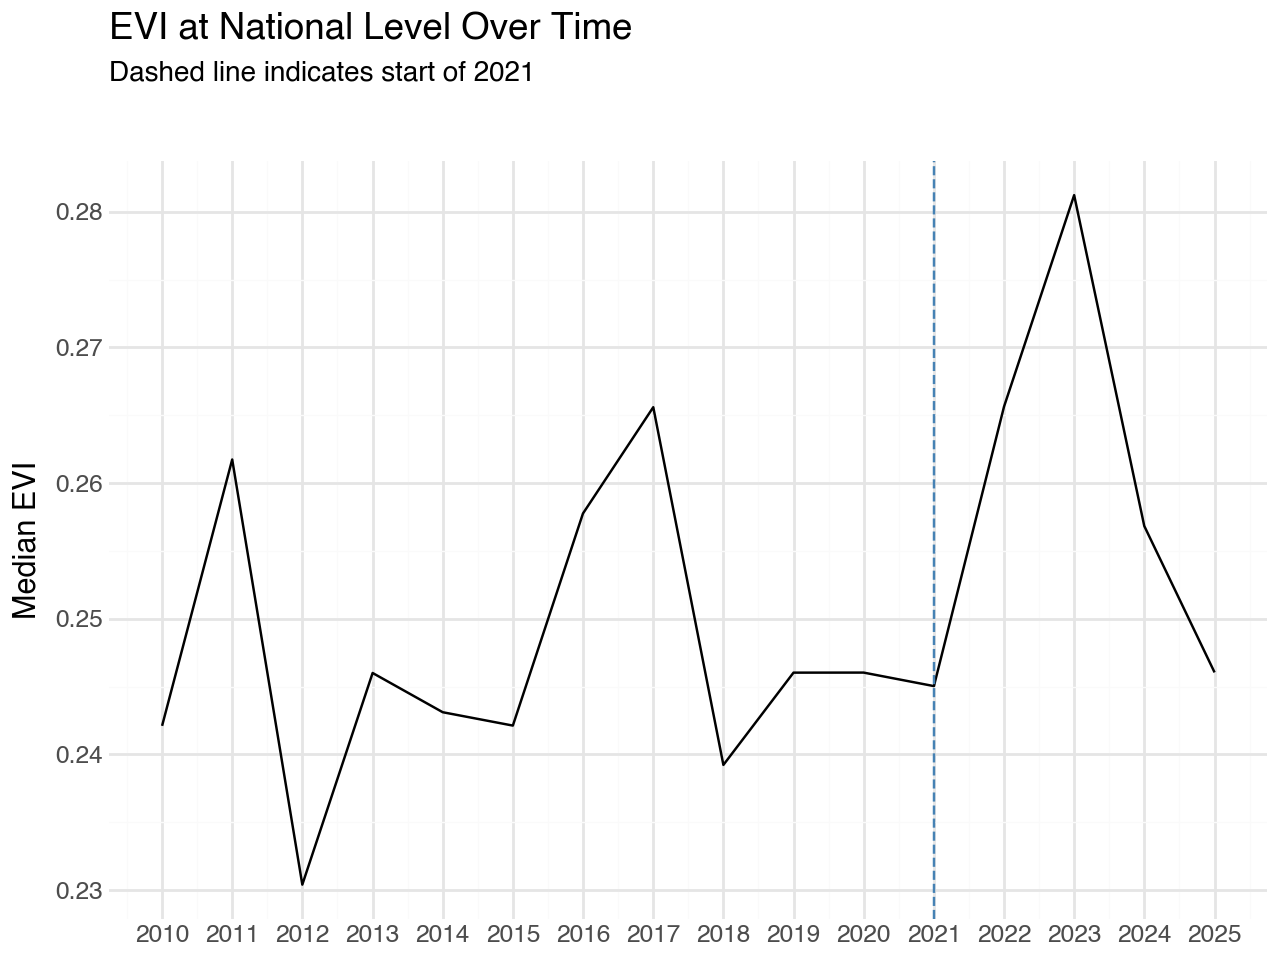

In [8]:
(
    evi_adm0_raw.groupby(pd.Grouper(freq="YS"))
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.geom_vline(
        p9.aes(xintercept=pd.to_datetime("2021-01-01")),
        linetype="dashed",
        color="steelblue",
    )
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="1 year")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI at National Level Over Time",
        subtitle="Dashed line indicates start of 2021",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

The figure below illustrates the trend of EVI values across administrative level 1 regions in Myanmar from 2012 to 2024, with a blue dotted line marking the 2021 coup d'état.

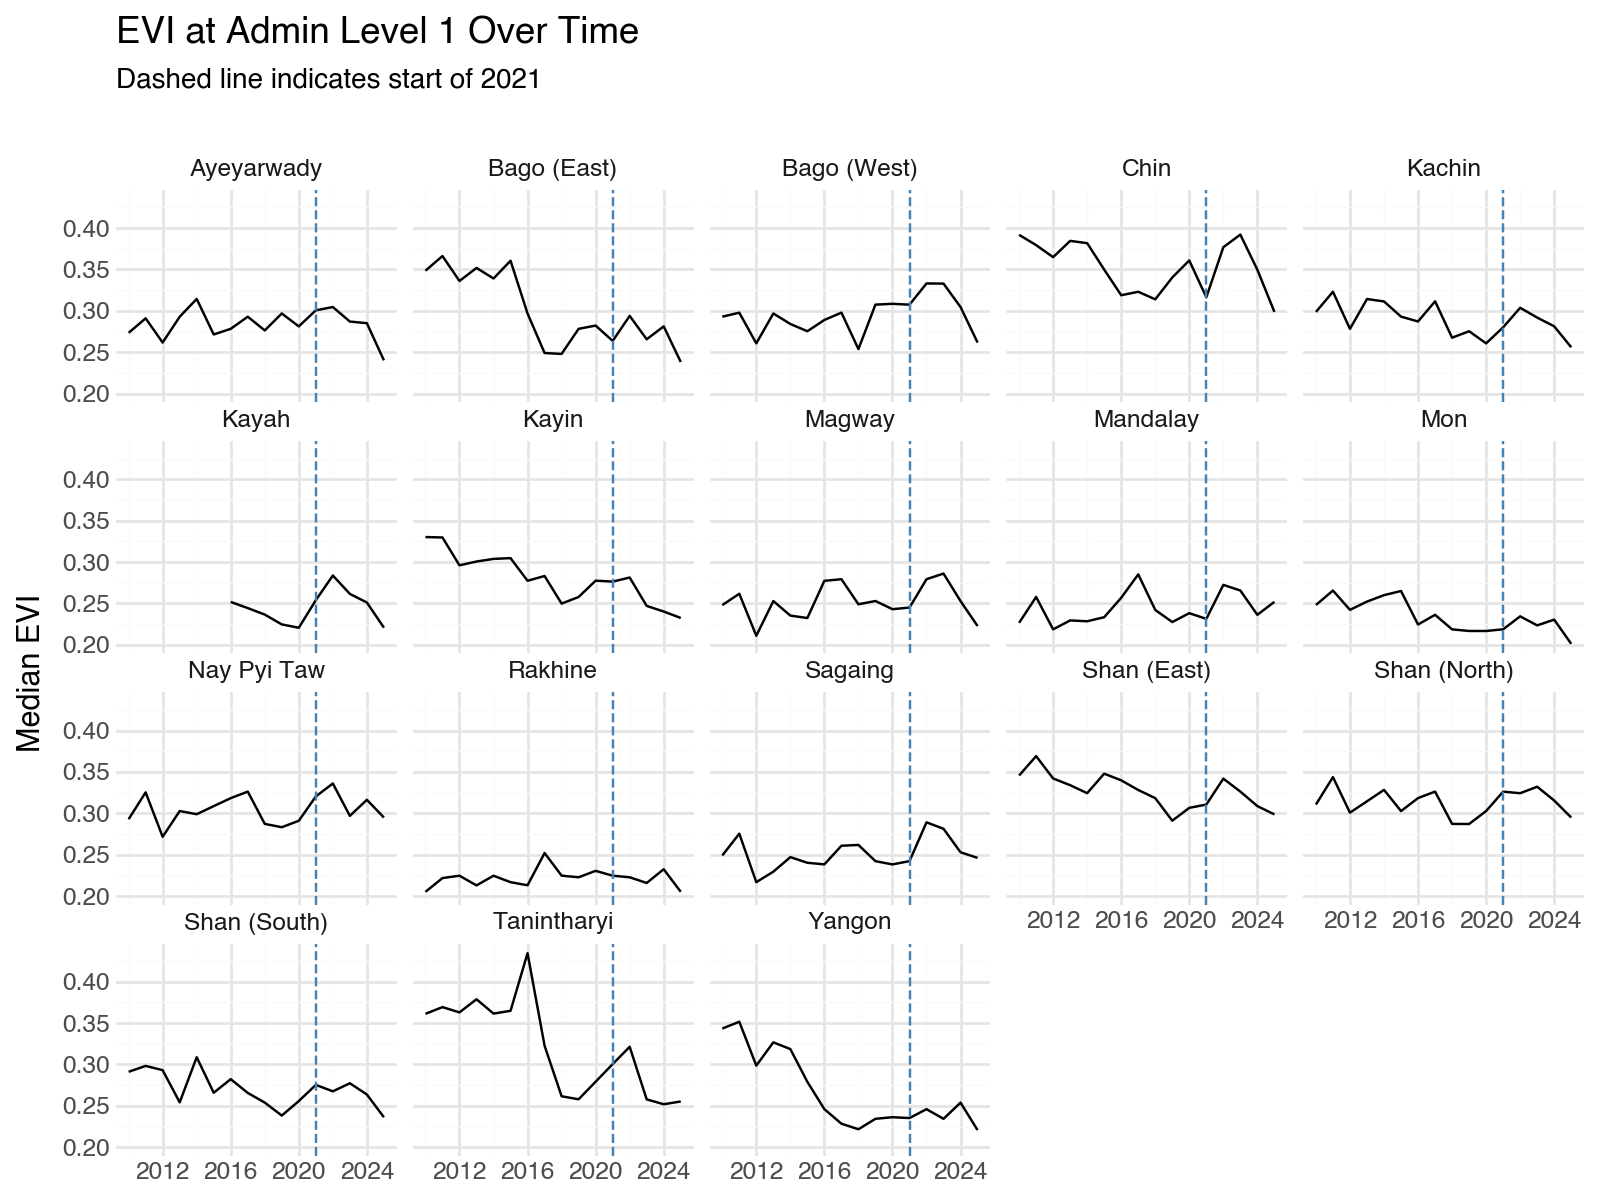

In [9]:
(
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="YS")])
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.geom_vline(
        p9.aes(xintercept=pd.to_datetime("2021-01-01")),
        linetype="dashed",
        color="steelblue",
    )
    + p9.facet_wrap("adm1_name")
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="4 year")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI at Admin Level 1 Over Time",
        subtitle="Dashed line indicates start of 2021",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        figure_size=(8, 6),
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

## GDP and Nigthtime Lights

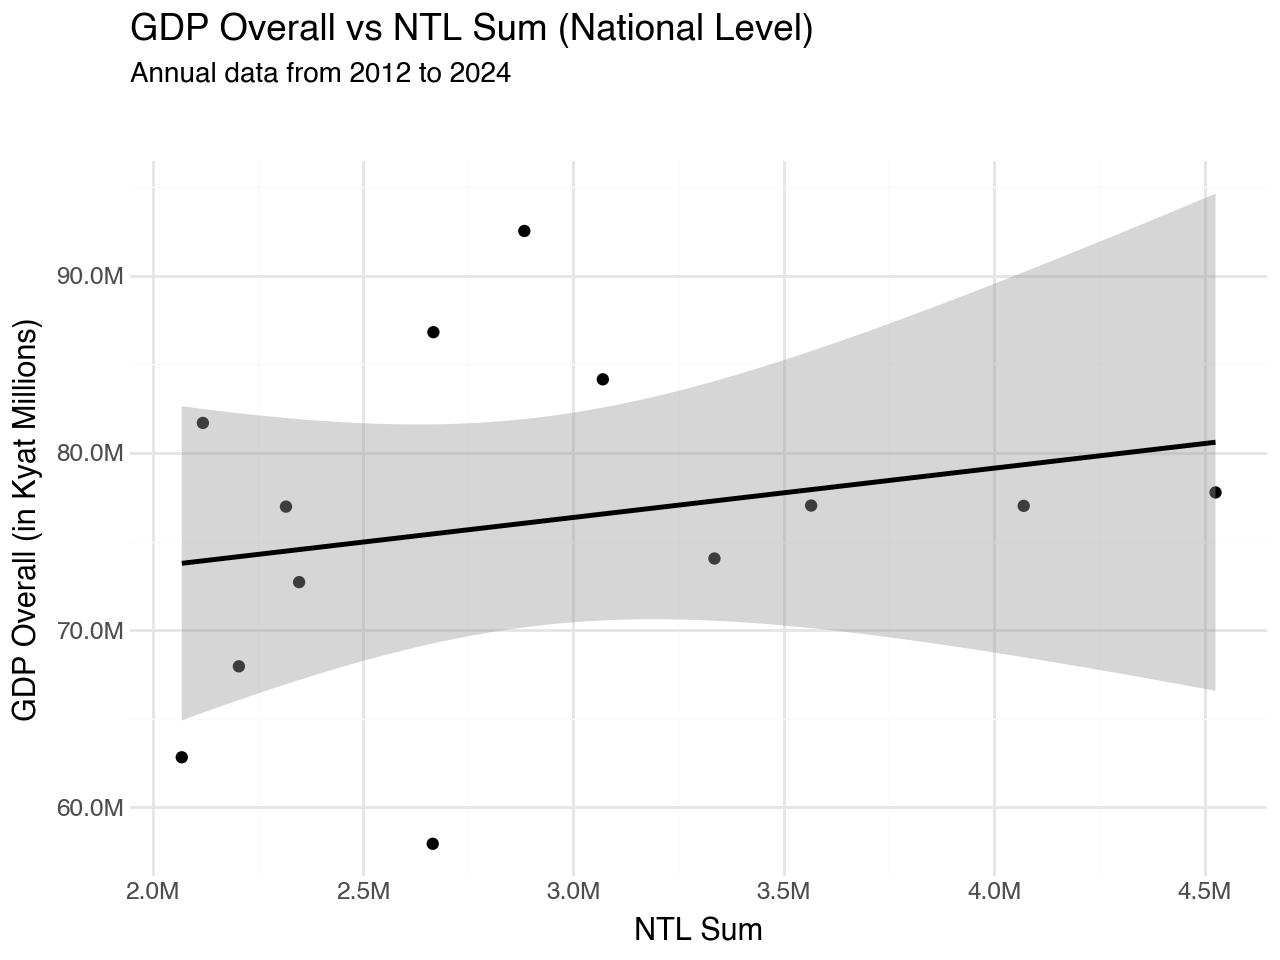

In [10]:
ntl_adm0_annual = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="YS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

(
    gdp_overall.join(ntl_adm0_annual, how="inner").pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_overall")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_x_continuous(labels=lambda l: format_currency_labels(l))
    + p9.scale_y_continuous(labels=lambda l: format_currency_labels(l))
    + p9.labs(
        title="GDP Overall vs NTL Sum (National Level)",
        subtitle="Annual data from 2012 to 2024",
        x="NTL Sum",
        y="GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

In [11]:
model_gdp_ntl_overall = smf.ols(
    "gdp_overall ~ ntl_sum", data=gdp_overall.join(ntl_adm0_annual, how="inner")
).fit()

model_gdp_ntl_overall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            gdp_overall   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.6025
Date:                Thu, 23 Oct 2025   Prob (F-statistic):              0.454
Time:                        16:29:56   Log-Likelihood:                -226.39
No. Observations:                  13   AIC:                             456.8
Df Residuals:                      11   BIC:                             457.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.802e+07   1.08e+07      6.317      0.000    4.43e+07    9.17e+07
ntl_sum        2.7813      3.583      0.776      0.454      -5.106      10.668
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   0.370
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.087
Skew:                          -0.010   Prob(JB):                        0.957
Kurtosis:                       2.600   Cond. No.                     1.21e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

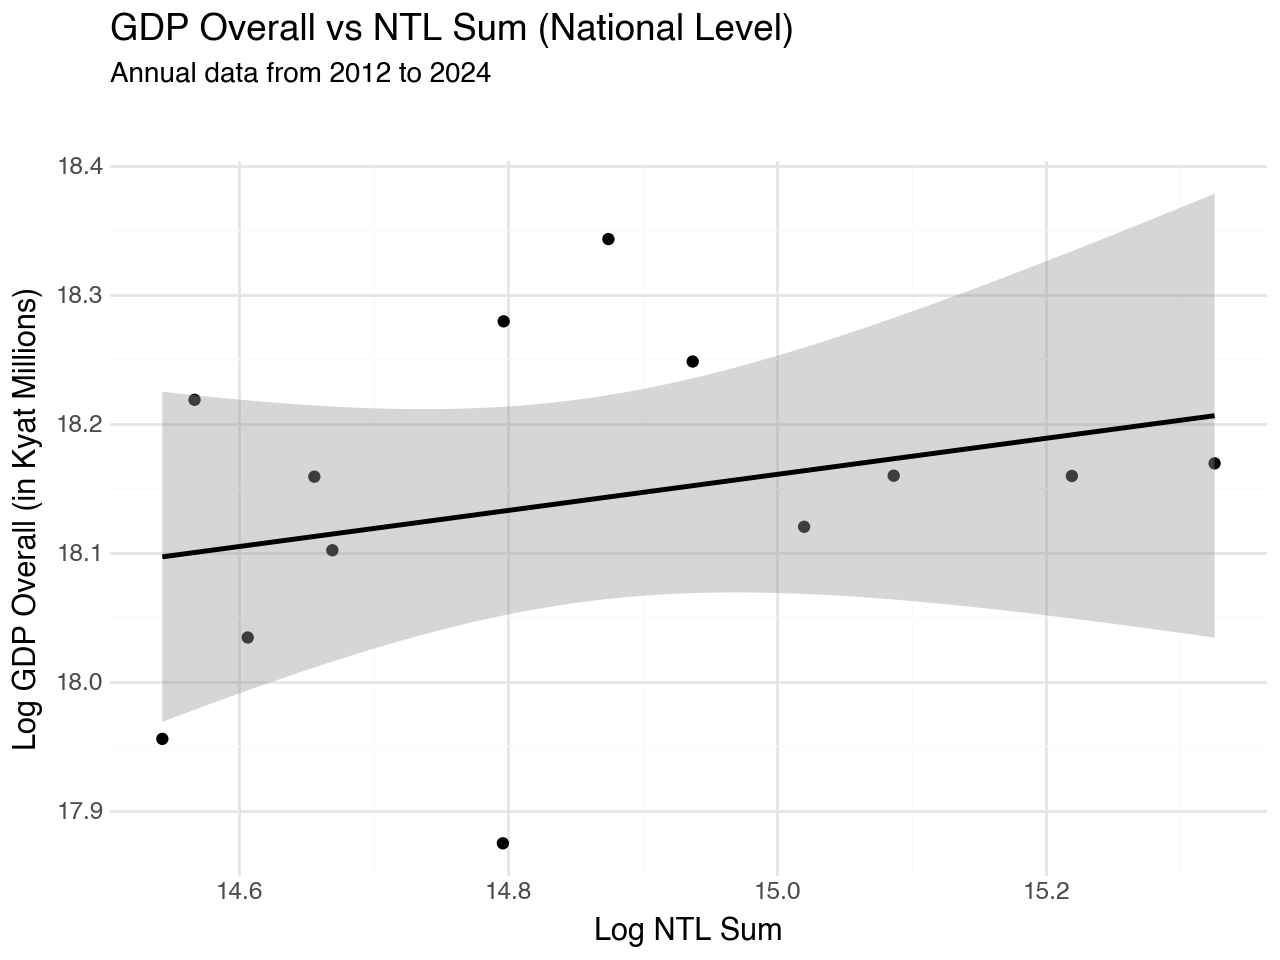

In [12]:
ntl_adm0_annual = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="YS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

(
    gdp_overall.join(ntl_adm0_annual, how="inner")
    .assign(
        ntl_sum_log=lambda df: np.log1p(df["ntl_sum"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs NTL Sum (National Level)",
        subtitle="Annual data from 2012 to 2024",
        x="Log NTL Sum",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

In [13]:
model_gdp_ntl_overall_log = smf.ols(
    "np.log1p(gdp_overall) ~ np.log1p(ntl_sum)",
    data=gdp_overall.join(ntl_adm0_annual, how="inner"),
).fit()

model_gdp_ntl_overall_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log1p(gdp_overall)   R-squared:                       0.076
Model:                               OLS   Adj. R-squared:                 -0.008
Method:                    Least Squares   F-statistic:                    0.8999
Date:                   Thu, 23 Oct 2025   Prob (F-statistic):              0.363
Time:                           16:29:56   Log-Likelihood:                 9.2761
No. Observations:                     13   AIC:                            -14.55
Df Residuals:                         11   BIC:                            -13.42
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            16.0652      2.188      7.343      0.000      11.250      20.880
np.log1p(ntl_sum)     0.1397      0.147      0.949      0.363      -0.184       0.464
==============================================================================
Omnibus:                        0.593   Durbin-Watson:                   0.360
Prob(Omnibus):                  0.743   Jarque-Bera (JB):                0.224
Skew:                          -0.304   Prob(JB):                        0.894
Kurtosis:                       2.788   Cond. No.                         913.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

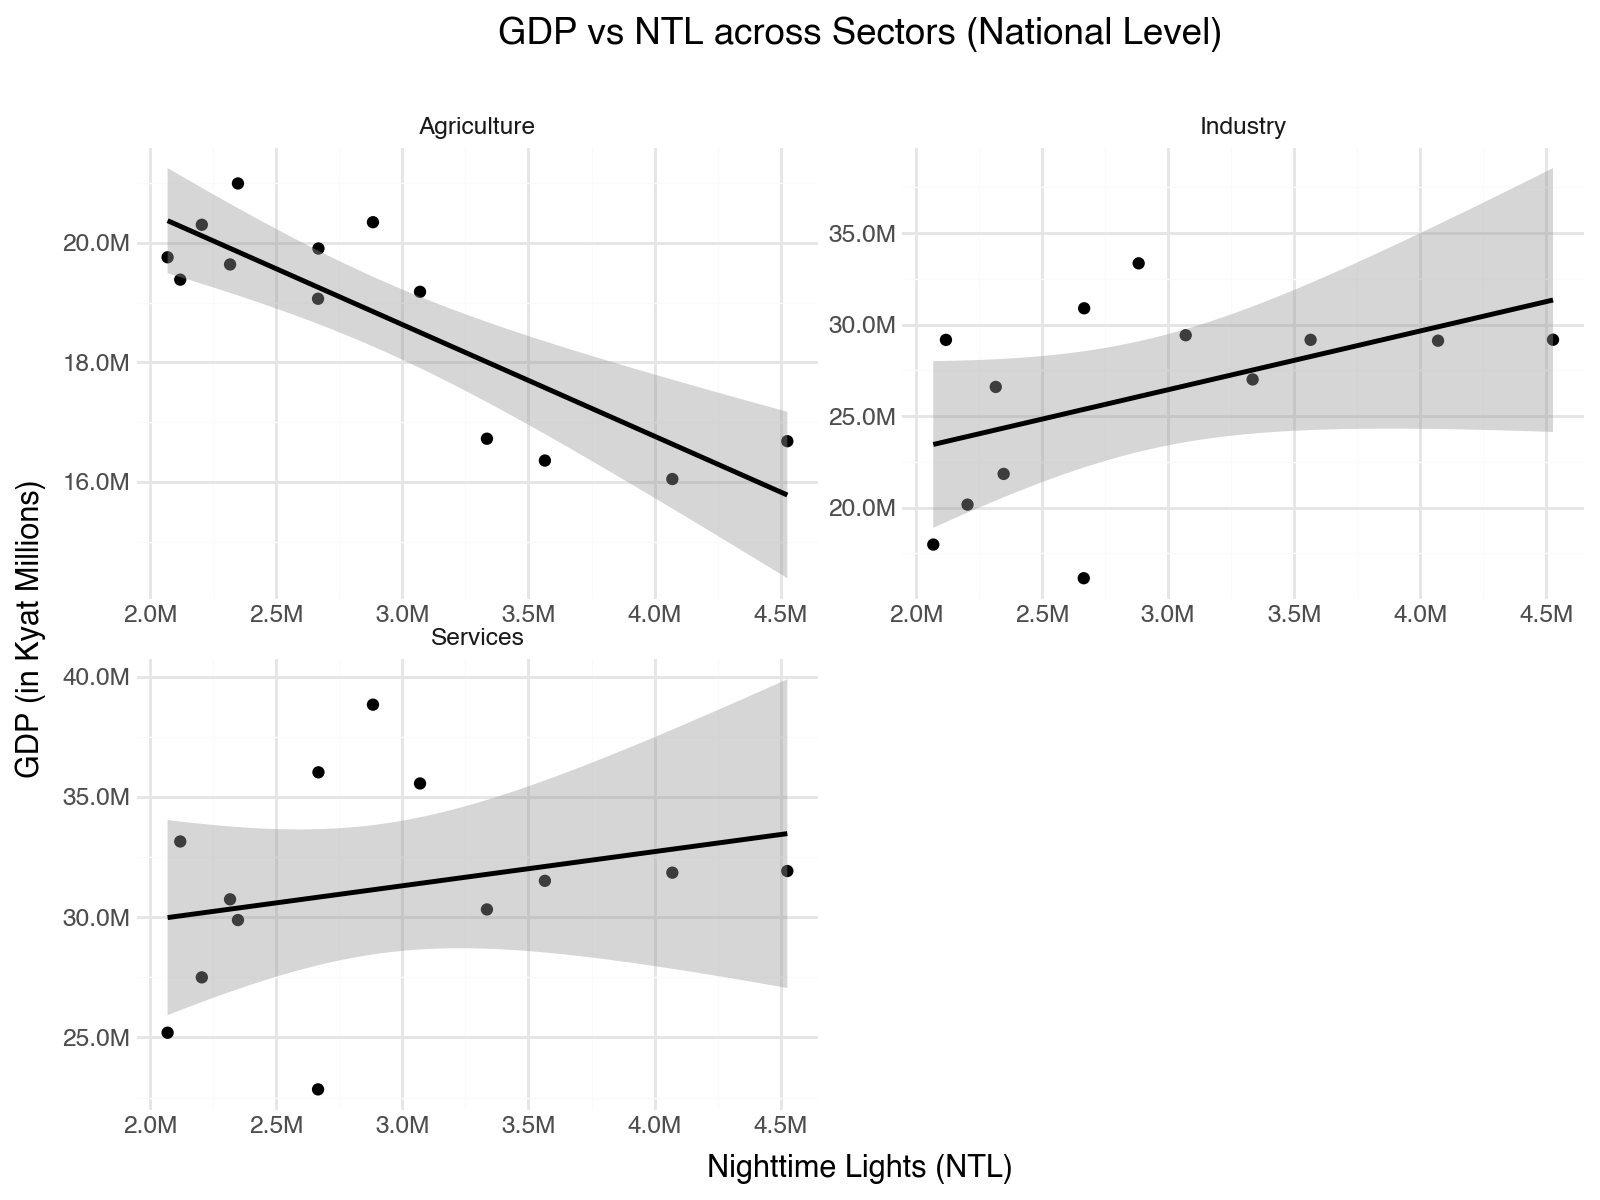

In [14]:
gdp_annual = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            (df["year"].str.split("-").str[0].str.strip() + df["quarter"].str.strip()),
        ),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    .set_index("date")
    .groupby(["sub_group", pd.Grouper(freq="YS")])
    .agg({"gdp": "sum"})
)

(
    gdp_annual.join(ntl_adm0_annual, how="inner")
    .reset_index()
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.scale_x_continuous(labels=lambda l: format_currency_labels(l))
    + p9.scale_y_continuous(labels=lambda l: format_currency_labels(l))
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        x="Nighttime Lights (NTL)",
        y="GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6),
        plot_title=p9.element_text(margin={"b": 20, "units": "pt"}),
    )
)

In [15]:
model_gdp_ntl_sectors = smf.ols(
    "gdp ~ ntl_sum + C(sub_group, Treatment(reference='Services'))",
    data=gdp_annual.join(ntl_adm0_annual, how="inner").reset_index(),
).fit()

model_gdp_ntl_sectors.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     20.36
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           8.27e-08
Time:                        16:29:56   Log-Likelihood:                -647.06
No. Observations:                  39   AIC:                             1302.
Df Residuals:                      35   BIC:                             1309.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     2.849e+07   2.81e+06     10.152      0.000    2.28e+07    3.42e+07
C(sub_group, Treatment(reference='Services'))[T.Agriculture] -1.238e+07   1.61e+06     -7.699      0.000   -1.56e+07   -9.12e+06
C(sub_group, Treatment(reference='Services'))[T.Industry]    -5.023e+06   1.61e+06     -3.123      0.004   -8.29e+06   -1.76e+06
ntl_sum                                                          0.9220      0.881      1.046      0.303      -0.868       2.711
==============================================================================
Omnibus:                        2.049   Durbin-Watson:                   0.525
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.433
Skew:                          -0.469   Prob(JB):                        0.488
Kurtosis:                       3.061   Cond. No.                     1.34e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

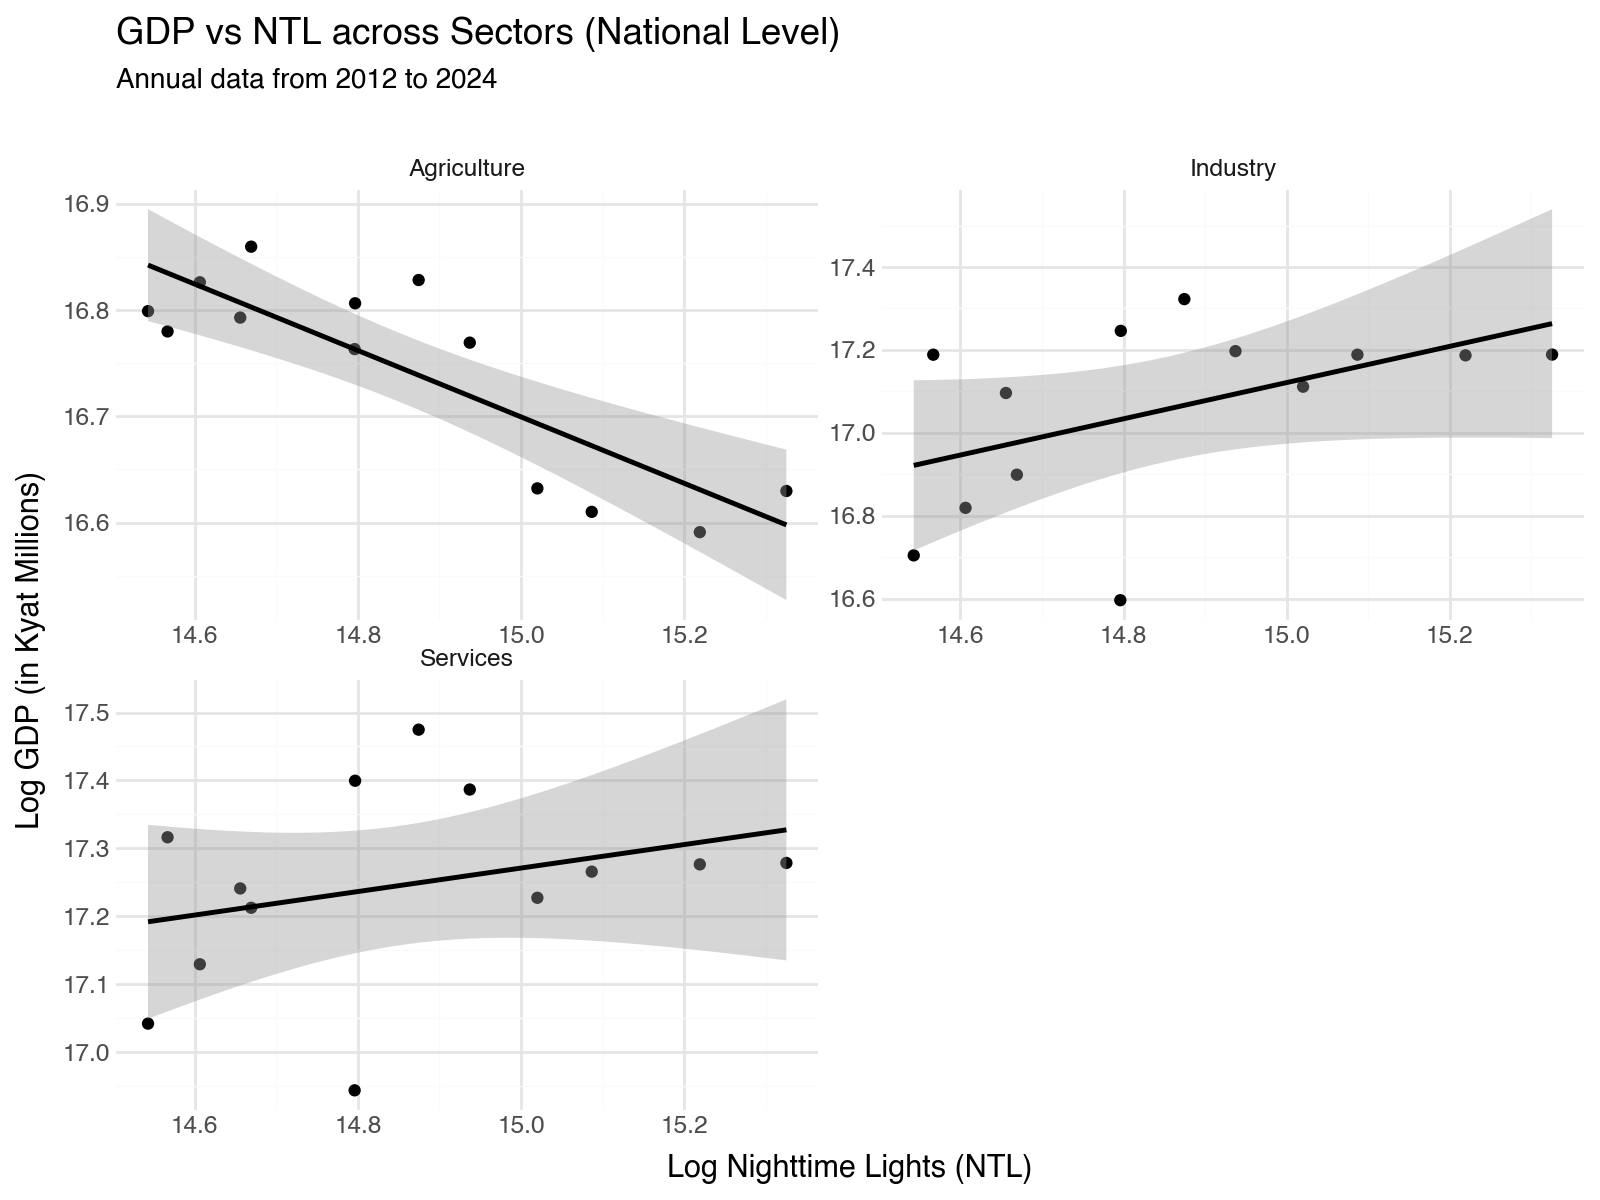

In [16]:
(
    gdp_annual.join(ntl_adm0_annual, how="inner")
    .reset_index()
    .assign(
        ntl_sum_log=lambda df: np.log1p(df["ntl_sum"]),
        gdp_log=lambda df: np.log1p(df["gdp"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        subtitle="Annual data from 2012 to 2024",
        x="Log Nighttime Lights (NTL)",
        y="Log GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(
        figure_size=(8, 6),
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

In [17]:
model_gdp_ntl_sectors_log = smf.ols(
    "np.log1p(gdp) ~ np.log1p(ntl_sum) + C(sub_group, Treatment(reference='Services'))",
    data=gdp_annual.join(ntl_adm0_annual, how="inner").reset_index(),
).fit()

model_gdp_ntl_sectors_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log1p(gdp)   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     20.66
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           7.02e-08
Time:                        16:29:56   Log-Likelihood:                 17.078
No. Observations:                  39   AIC:                            -26.16
Df Residuals:                      35   BIC:                            -19.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       15.7747      1.616      9.761      0.000      12.494      19.056
C(sub_group, Treatment(reference='Services'))[T.Agriculture]    -0.5006      0.065     -7.742      0.000      -0.632      -0.369
C(sub_group, Treatment(reference='Services'))[T.Industry]       -0.1884      0.065     -2.914      0.006      -0.320      -0.057
np.log1p(ntl_sum)                                                0.0990      0.109      0.911      0.369      -0.122       0.320
==============================================================================
Omnibus:                        6.399   Durbin-Watson:                   0.486
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                5.274
Skew:                          -0.875   Prob(JB):                       0.0716
Kurtosis:                       3.424   Cond. No.                         914.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

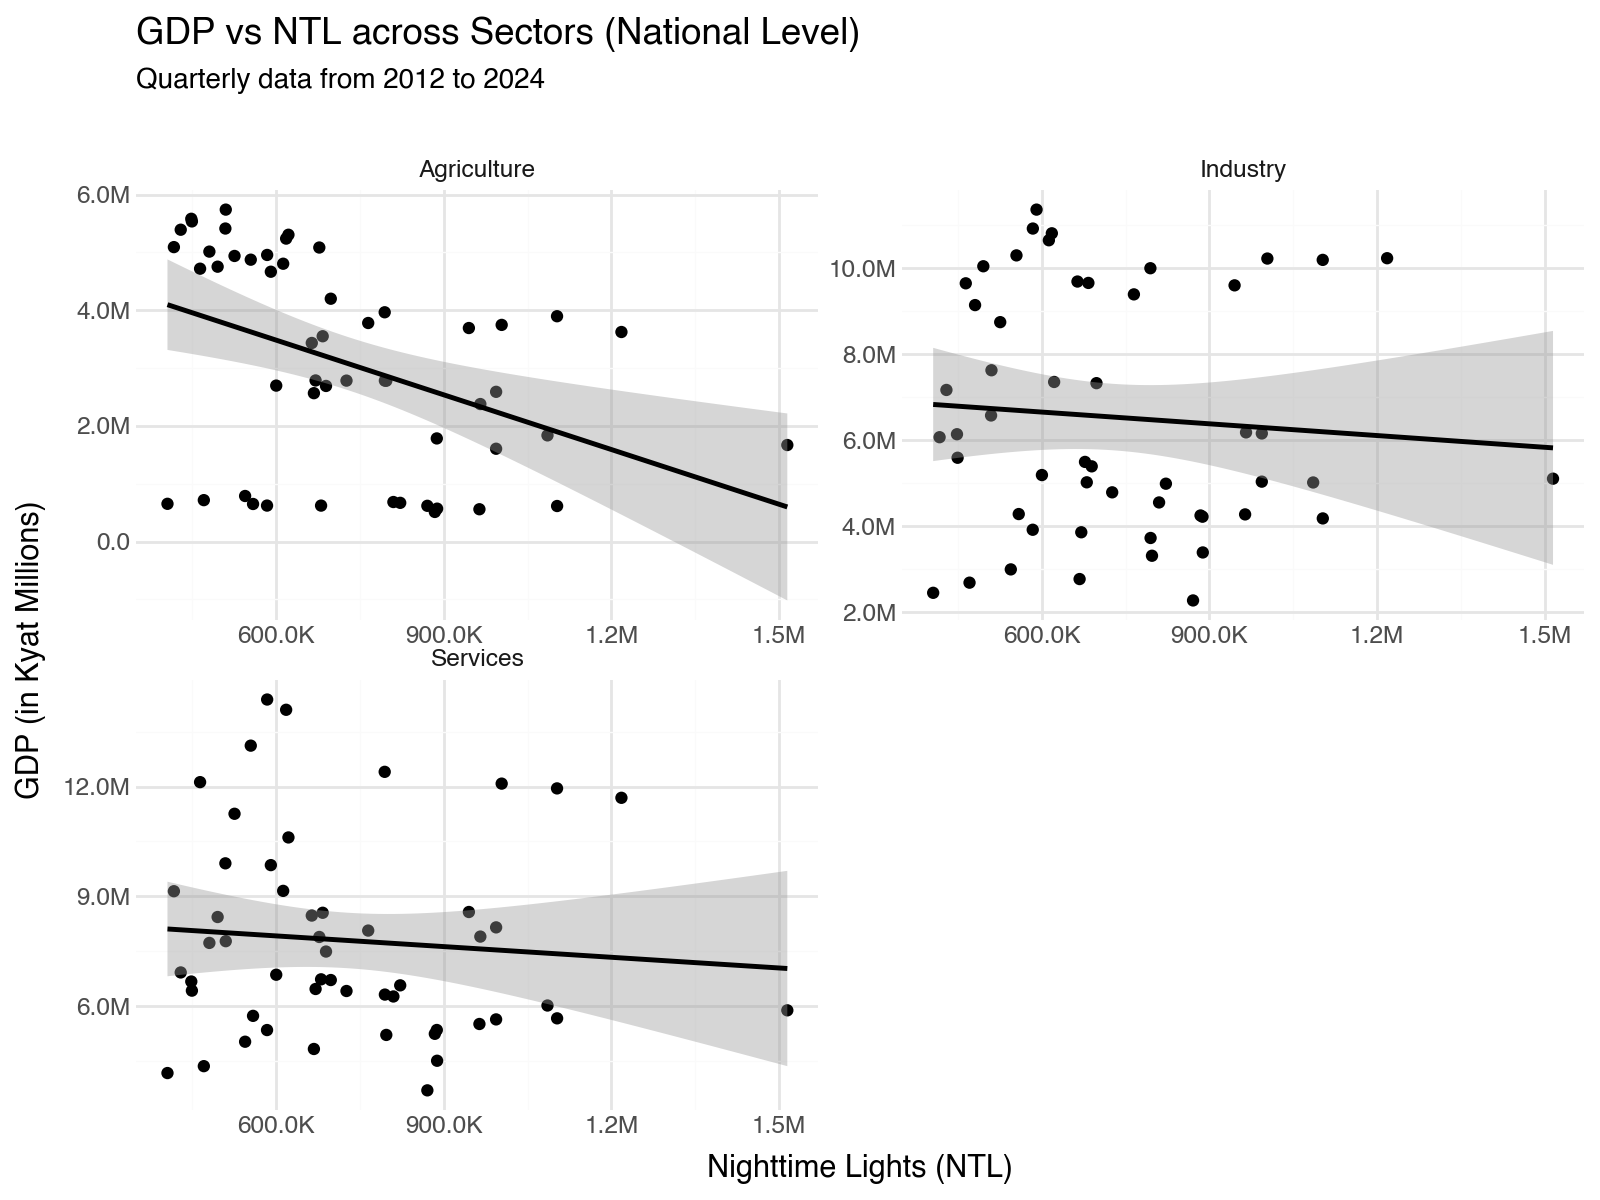

In [18]:
(
    gdp_quarterly.join(ntl_adm0, how="inner").reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.scale_x_continuous(labels=lambda l: format_currency_labels(l))
    + p9.scale_y_continuous(labels=lambda l: format_currency_labels(l))
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        subtitle="Quarterly data from 2012 to 2024",
        x="Nighttime Lights (NTL)",
        y="GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(8, 6))
    + p9.theme(
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

In [19]:
model_gdp_ntl_quarterly_sectors = smf.ols(
    "gdp ~ ntl_sum + C(sub_group, Treatment(reference='Services'))",
    data=gdp_quarterly.join(ntl_adm0, how="inner").reset_index(),
).fit()

model_gdp_ntl_quarterly_sectors.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    gdp   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     36.20
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           1.03e-17
Time:                        16:29:56   Log-Likelihood:                -2513.3
No. Observations:                 156   AIC:                             5035.
Df Residuals:                     152   BIC:                             5047.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     9.017e+06   6.96e+05     12.964      0.000    7.64e+06    1.04e+07
C(sub_group, Treatment(reference='Services'))[T.Agriculture] -4.712e+06   4.77e+05     -9.873      0.000   -5.66e+06   -3.77e+06
C(sub_group, Treatment(reference='Services'))[T.Industry]    -1.256e+06   4.77e+05     -2.631      0.009    -2.2e+06   -3.13e+05
ntl_sum                                                         -1.6800      0.836     -2.010      0.046      -3.331      -0.029
==============================================================================
Omnibus:                        6.710   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                6.328
Skew:                           0.435   Prob(JB):                       0.0423
Kurtosis:                       2.535   Cond. No.                     3.01e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

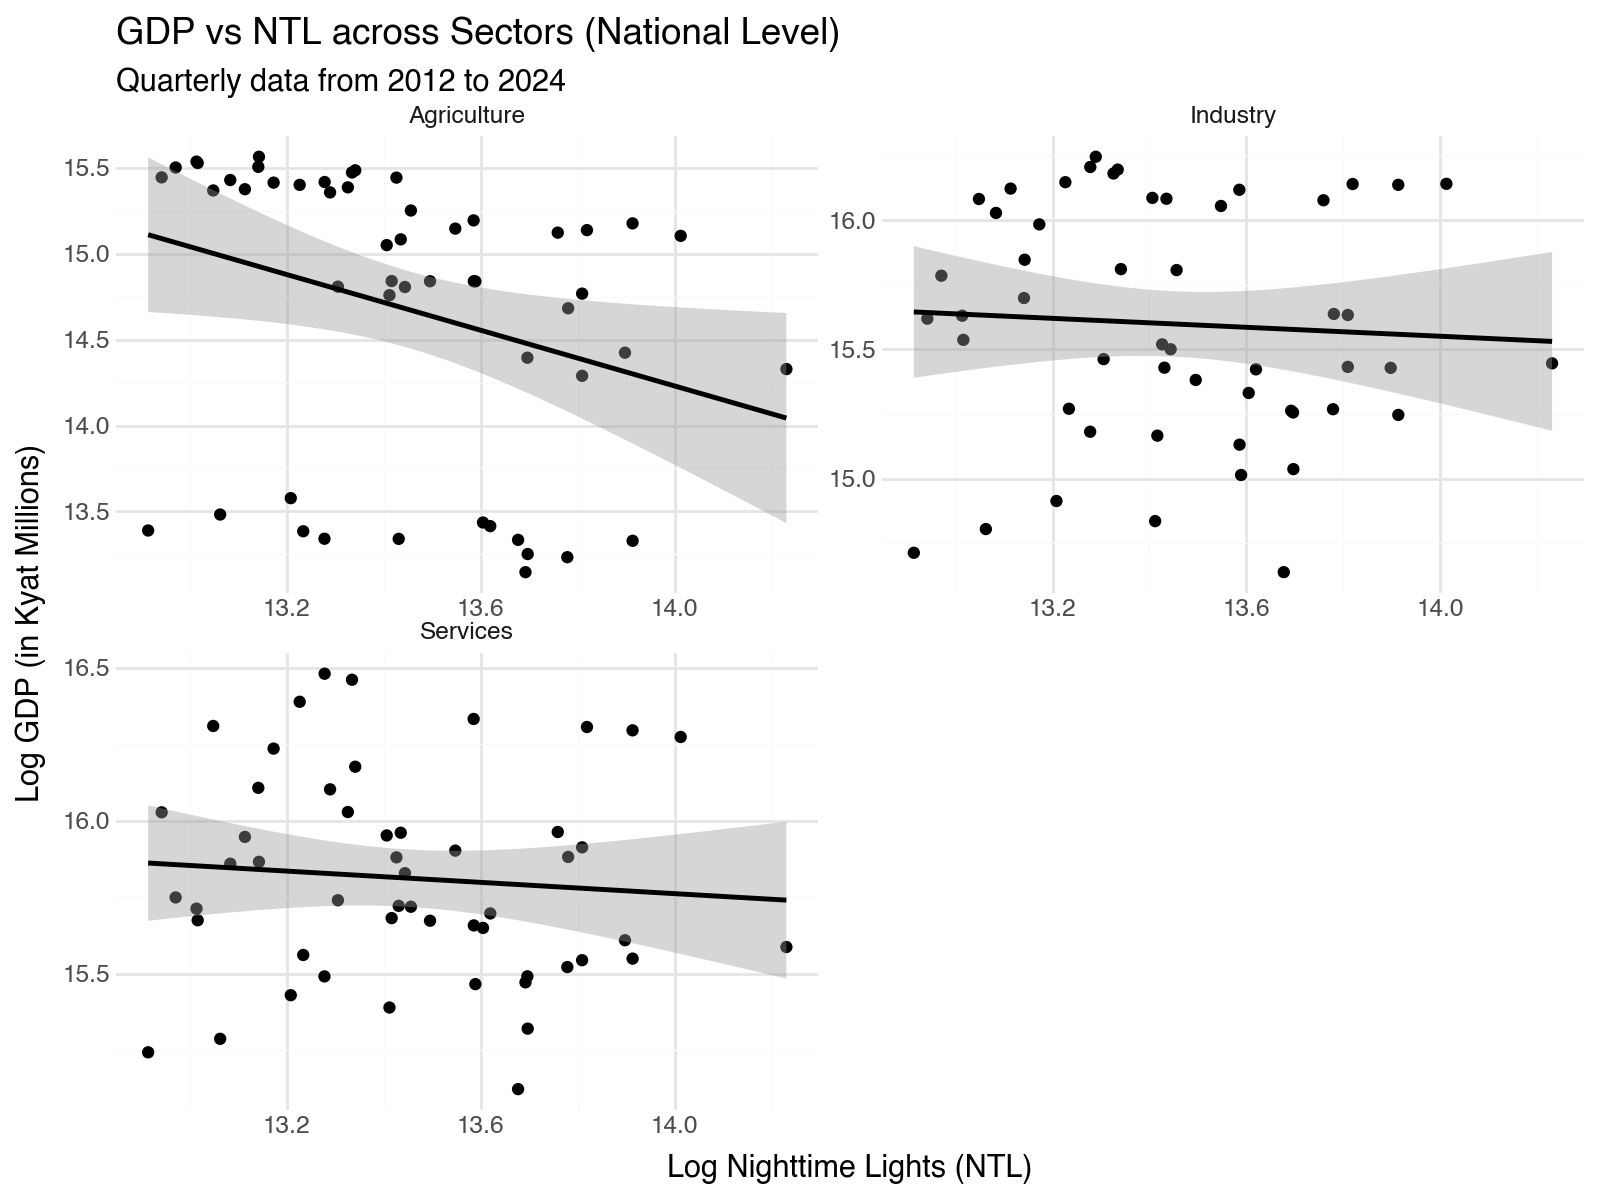

In [20]:
(
    gdp_quarterly.join(ntl_adm0, how="inner")
    .reset_index()
    .assign(
        ntl_sum_log=lambda df: np.log1p(df["ntl_sum"]),
        gdp_log=lambda df: np.log1p(df["gdp"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum_log", y="gdp_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("sub_group", scales="free", ncol=2)
    + p9.labs(
        title="GDP vs NTL across Sectors (National Level)",
        subtitle="Quarterly data from 2012 to 2024",
        x="Log Nighttime Lights (NTL)",
        y="Log GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(8, 6))
)

In [21]:
model_gdp_ntl_quarterly_sectors_log = smf.ols(
    "np.log1p(gdp) ~ np.log1p(ntl_sum) + C(sub_group, Treatment(reference='Services'))",
    data=gdp_quarterly.join(ntl_adm0, how="inner").reset_index(),
).fit()

model_gdp_ntl_quarterly_sectors_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log1p(gdp)   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     40.15
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           3.63e-19
Time:                        16:29:57   Log-Likelihood:                -132.50
No. Observations:                 156   AIC:                             273.0
Df Residuals:                     152   BIC:                             285.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       20.2459      2.012     10.065      0.000      16.272      24.220
C(sub_group, Treatment(reference='Services'))[T.Agriculture]    -1.1371      0.112    -10.117      0.000      -1.359      -0.915
C(sub_group, Treatment(reference='Services'))[T.Industry]       -0.2144      0.112     -1.908      0.058      -0.436       0.008
np.log1p(ntl_sum)                                               -0.3296      0.149     -2.205      0.029      -0.625      -0.034
==============================================================================
Omnibus:                       16.616   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.997
Skew:                          -0.849   Prob(JB):                     7.50e-05
Kurtosis:                       3.203   Cond. No.                         593.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

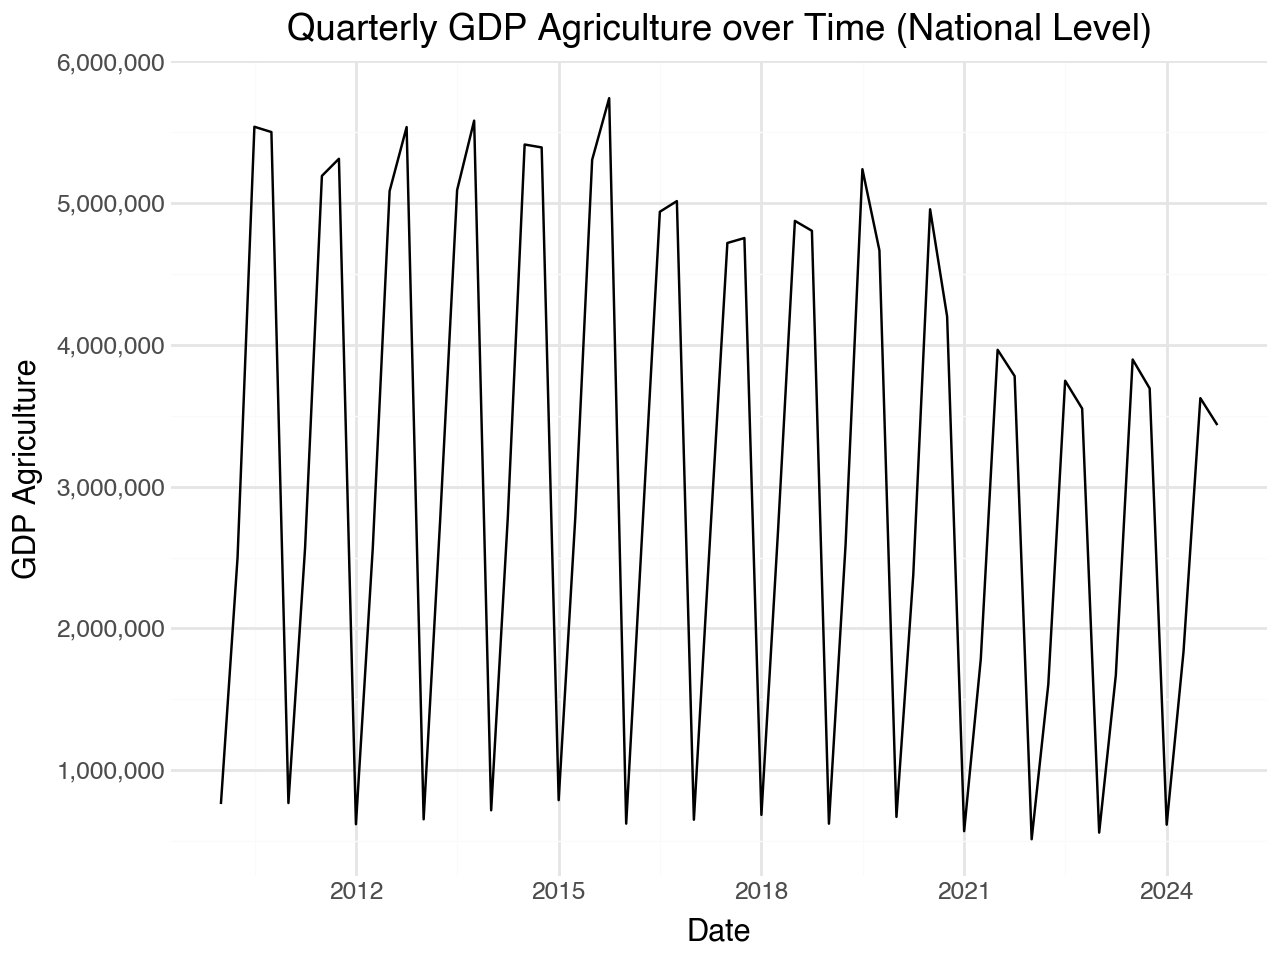

In [22]:
(
    gdp_agri_quarterly.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="gdp_agri")
    + p9.geom_line()
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="Quarterly GDP Agriculture over Time (National Level)",
        x="Date",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

## GDP and EVI

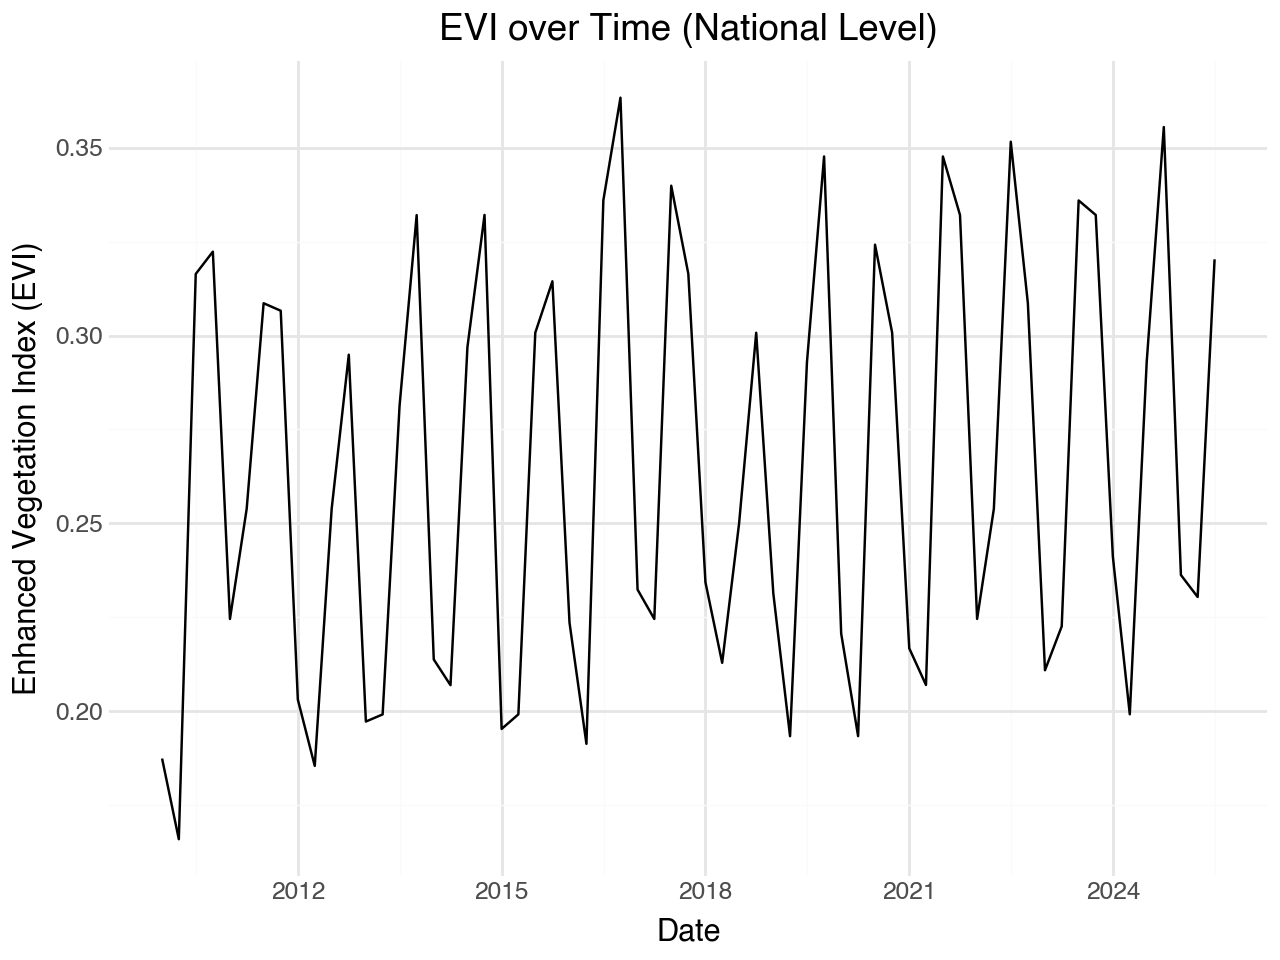

In [23]:
(
    evi_adm0.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="EVI over Time (National Level)",
        x="Date",
        y="Enhanced Vegetation Index (EVI)",
    )
    + p9.theme_minimal()
)

### Admin Level 0

In [24]:
evi_indicators = (
    gdp_agri_quarterly.join(evi_adm0, how="left")
    .join(ntl_adm0, how="left")
    .assign(
        evi_lag_1=lambda df: df["evi"].shift(1),
        evi_lag_2=lambda df: df["evi"].shift(2),
        ntl_mean_lag_1=lambda df: df["ntl_mean"].shift(1),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
        evi_lag_1_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_1"]]),
        evi_lag_2_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_2"]]),
    )
)

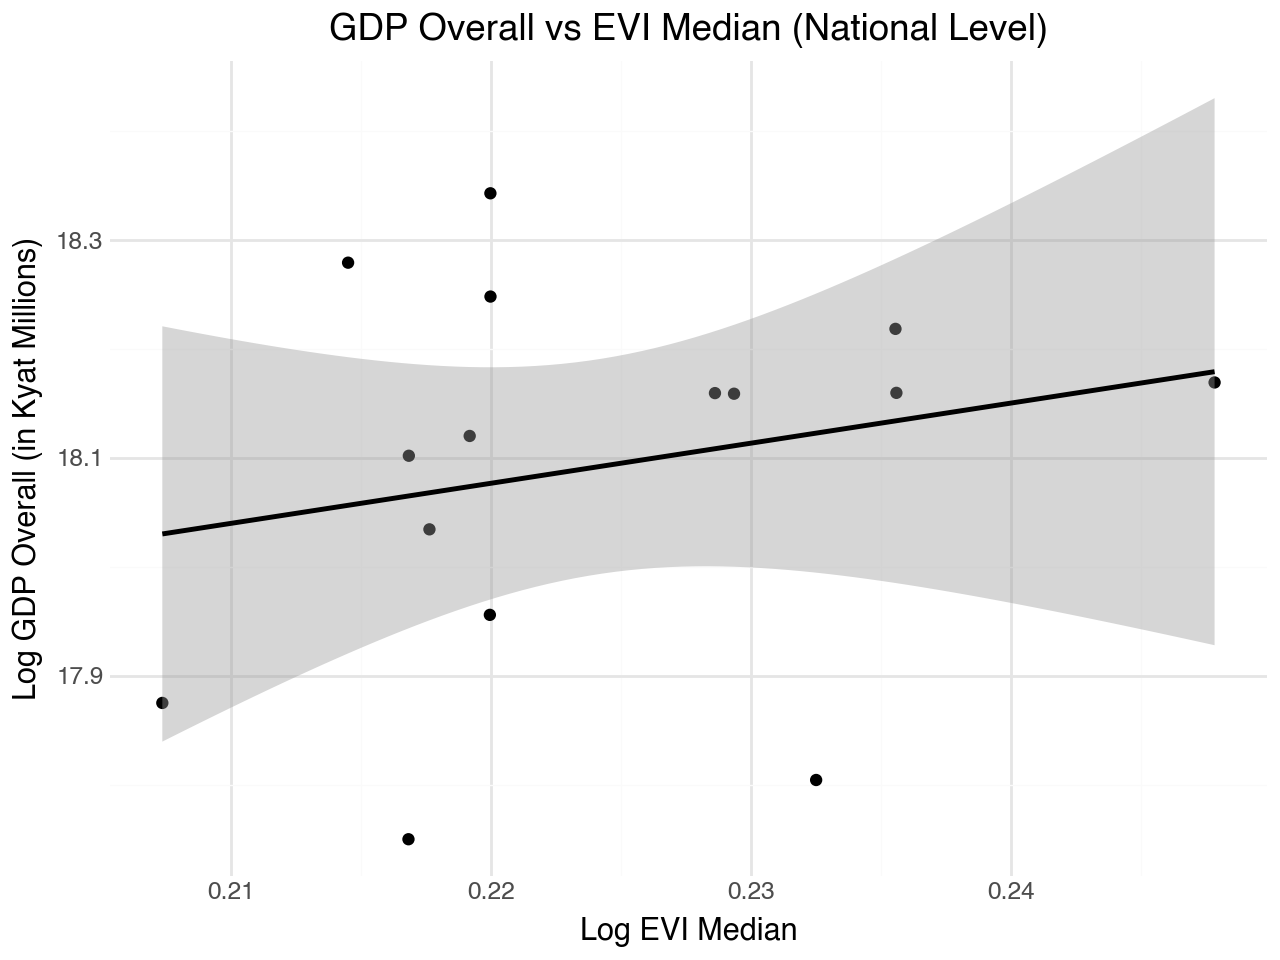

In [25]:
evi_adm0_annual = (
    evi_adm0_raw.groupby(pd.Grouper(freq="YS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    evi_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        evi_log=lambda df: np.log1p(df["evi"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs EVI Median (National Level)",
        x="Log EVI Median",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

In [26]:
model_gdp_evi_overall_log = smf.ols(
    "np.log1p(gdp_overall) ~ np.log1p(evi)",
    data=evi_adm0_annual.join(gdp_overall, how="inner"),
).fit()

model_gdp_evi_overall_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log1p(gdp_overall)   R-squared:                       0.049
Model:                               OLS   Adj. R-squared:                 -0.024
Method:                    Least Squares   F-statistic:                    0.6670
Date:                   Thu, 23 Oct 2025   Prob (F-statistic):              0.429
Time:                           16:29:57   Log-Likelihood:                 5.7683
No. Observations:                     15   AIC:                            -7.537
Df Residuals:                         13   BIC:                            -6.120
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.2666      1.011     17.071      0.000      15.081      19.452
np.log1p(evi)     3.6825      4.509      0.817      0.429      -6.058      13.423
==============================================================================
Omnibus:                        1.052   Durbin-Watson:                   0.228
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.683
Skew:                          -0.495   Prob(JB):                        0.711
Kurtosis:                       2.663   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

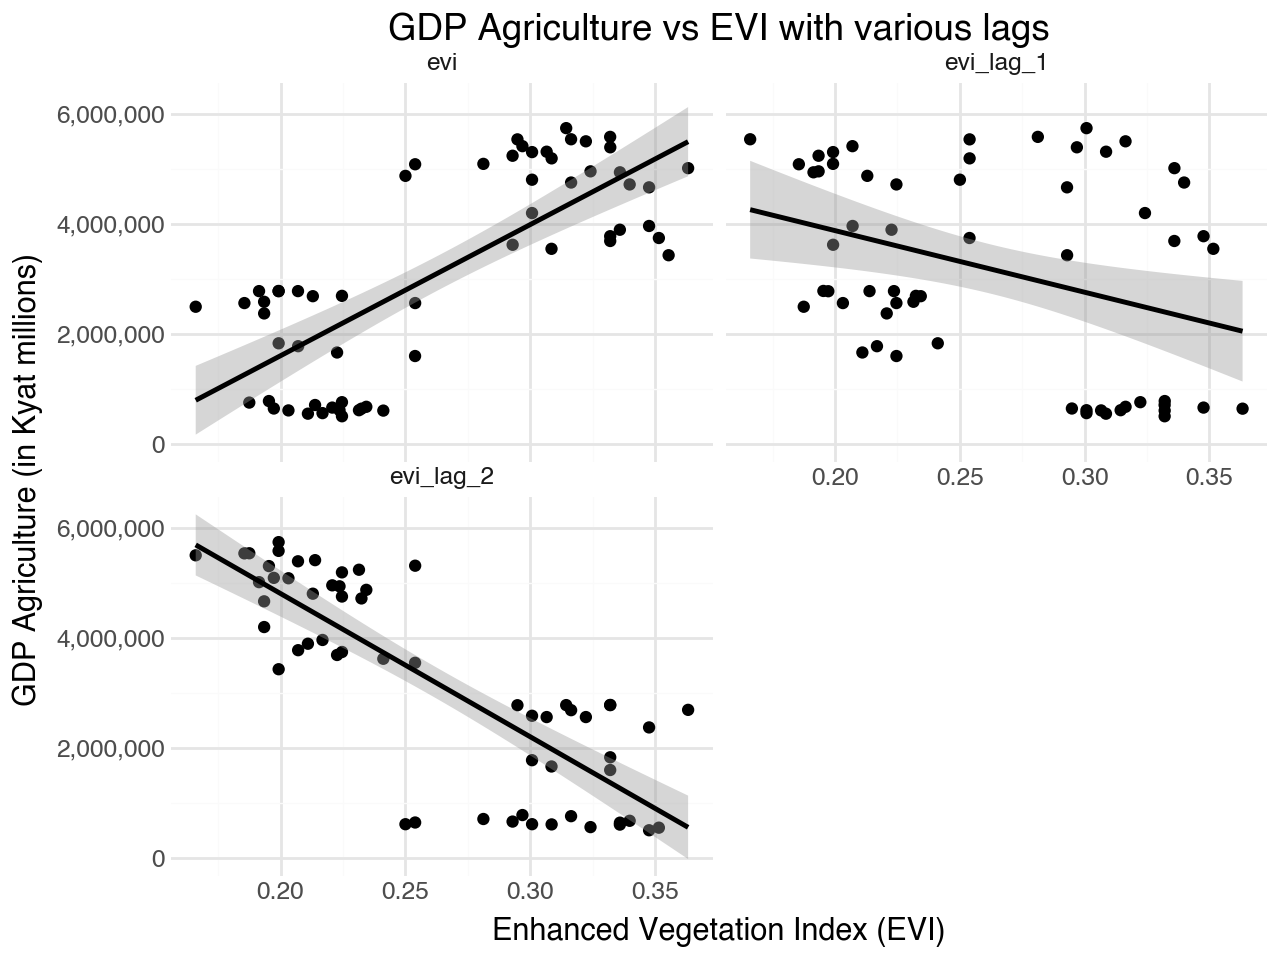

In [27]:
(
    evi_indicators.filter(["gdp_agri", "evi", "evi_lag_1", "evi_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_agri", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Agriculture vs EVI with various lags",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

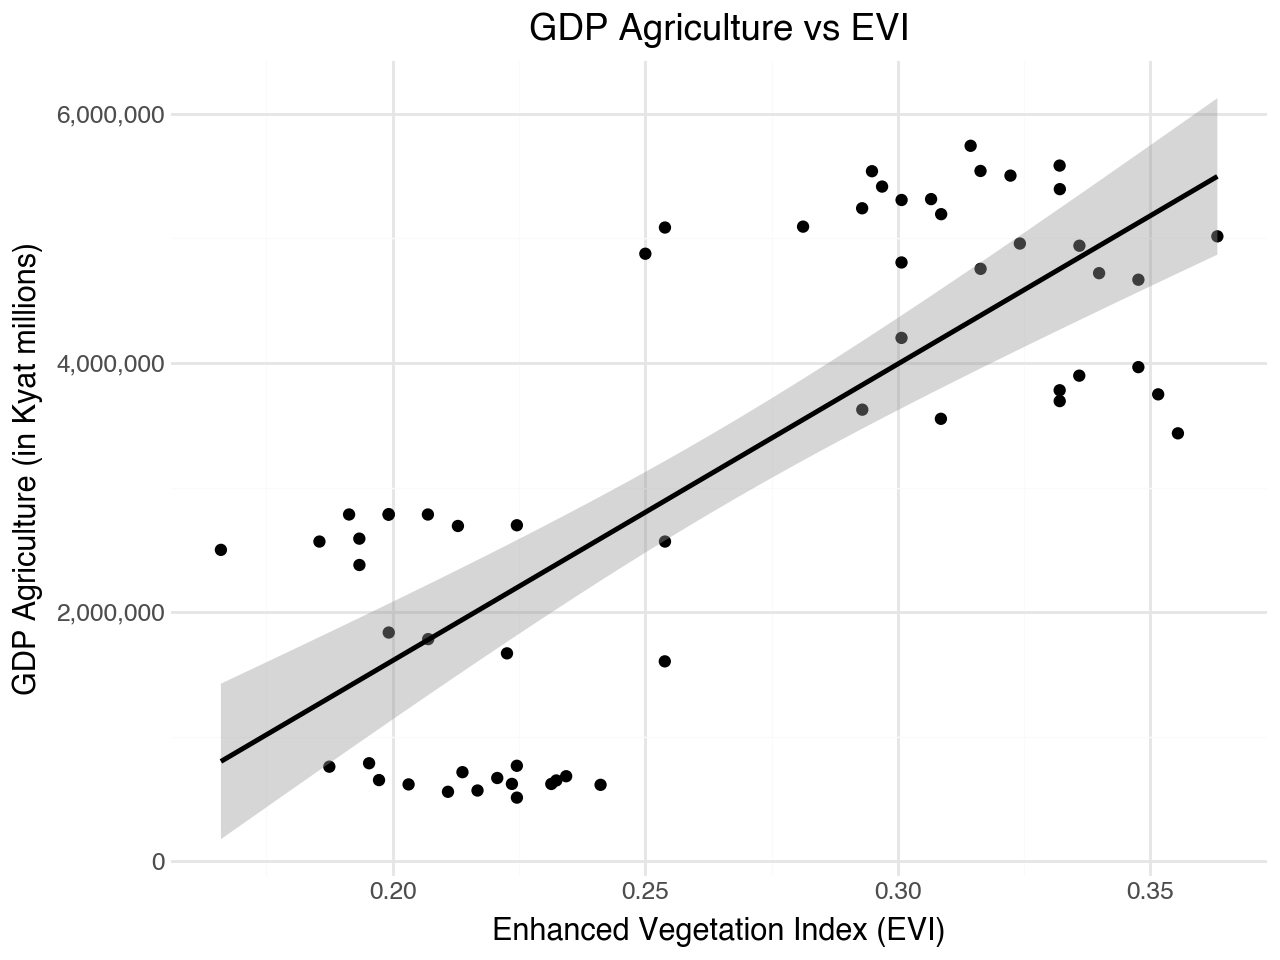

In [28]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

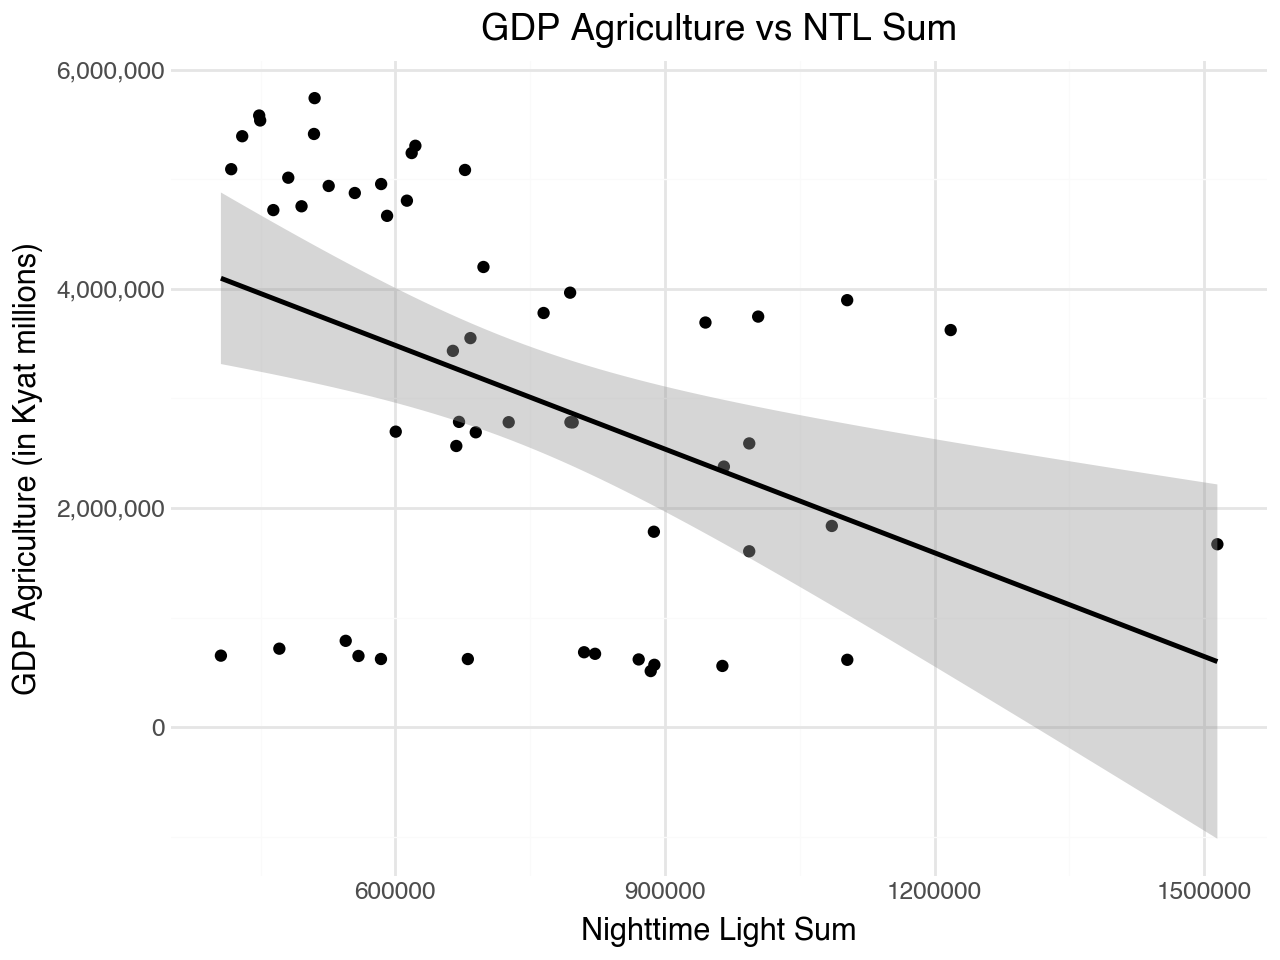

In [29]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

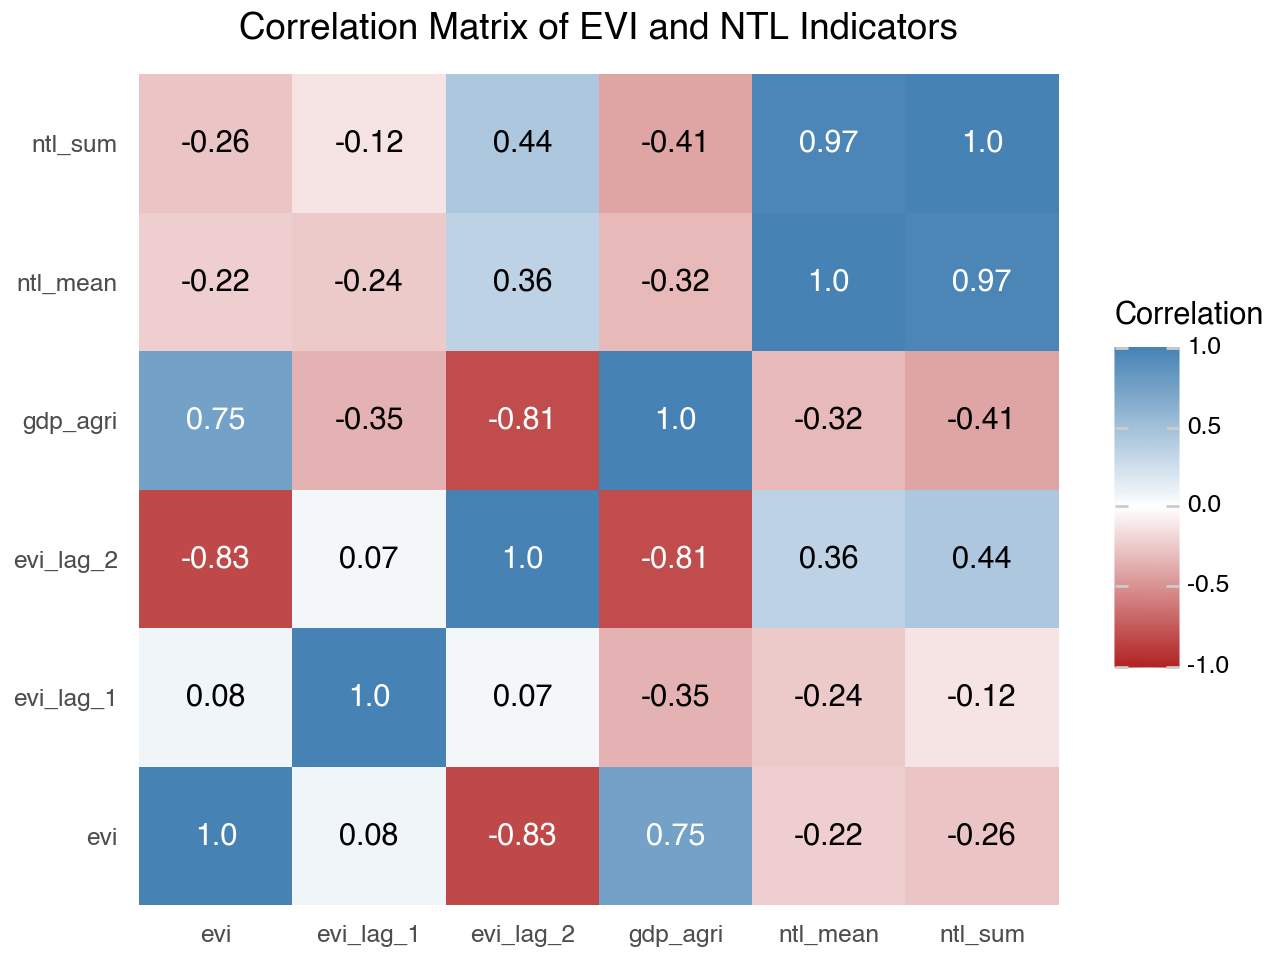

In [30]:
(
    evi_indicators.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(
        title="Correlation Matrix of EVI and NTL Indicators",
        fill="Correlation",
        x="",
        y="",
    )
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [31]:
mod_1 = smf.ols("gdp_agri ~ evi", data=evi_indicators).fit()
mod_2 = smf.ols("gdp_agri ~ ntl_sum + evi", data=evi_indicators).fit()
mod_3 = smf.ols(
    "gdp_agri ~ ntl_sum + evi + evi_lag_1 + evi_lag_2", data=evi_indicators
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [32]:
mod_1 = smf.ols("np.log1p(gdp_agri) ~ np.log1p(evi)", data=evi_indicators).fit()
mod_2 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi)", data=evi_indicators
).fit()
mod_3 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + np.log1p(evi_lag_1) + np.log1p(evi_lag_2)",
    data=evi_indicators,
).fit()

Stargazer([mod_1, mod_2, mod_3])

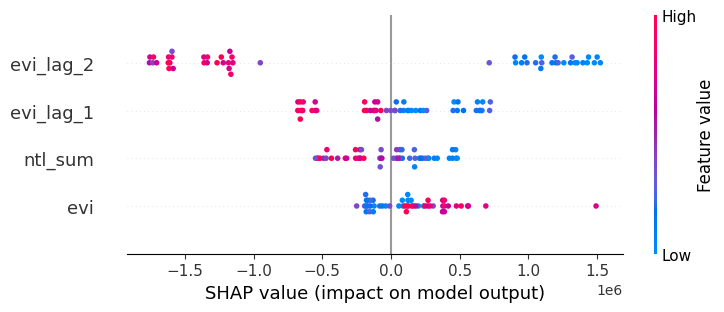

In [33]:
evi_indicators_clean = evi_indicators.dropna()
X = evi_indicators_clean[["evi", "ntl_sum", "evi_lag_1", "evi_lag_2"]]
y = evi_indicators_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### Admin Level 1

The Sectoral GDP at admin level 1 for all years was estimated based on the sectoral GDP proportions observed in 2015-2016. The proportions were assumed to remain constant over the years as shown below:

In [34]:
(
    gdp_adm1.filter(["adm1_name", "agriculture_pct", "industry_pct", "services_pct"])
    .assign(
        agriculture_pct=lambda df: df["agriculture_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        ),
        industry_pct=lambda df: df["industry_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        ),
        services_pct=lambda df: df["services_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        ),
    )
    .rename(
        columns={
            "agriculture_pct": "Agriculture",
            "industry_pct": "Industry",
            "services_pct": "Services",
        }
    )
)

adm1_name Agriculture Industry Services
0     Ayeyarwady       16.0%     5.1%    10.1%
1           Chin        0.5%     0.3%     0.3%
2         Kachin        2.1%     1.9%     1.8%
3          Kayah        0.5%     0.2%     0.3%
4          Kayin        2.4%     1.3%     1.9%
5         Magway       14.1%     7.9%     7.4%
6       Mandalay        8.3%    12.3%    12.5%
7            Mon        4.4%     4.1%     4.3%
8    Nay Pyi Taw        1.1%     1.7%     3.3%
9        Rakhine        3.3%     2.6%     4.6%
10       Sagaing       17.0%    12.8%     8.2%
11   Tanintharyi        6.9%     2.0%     2.5%
12        Yangon        4.9%    35.4%    28.5%
13   Bago (East)        5.3%     3.7%     4.2%
14   Bago (West)        5.3%     3.7%     4.2%
15  Shan (South)        2.7%     1.7%     2.0%
16   Shan (East)        2.7%     1.7%     2.0%
17  Shan (North)        2.7%     1.7%     2.0%

In [35]:
evi_indicators_adm1 = (
    gdp_agri_quarterly_adm1.join(evi_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_agri_c=lambda df: df["gdp_agri"] - df["gdp_agri"].mean(),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            evi_lag_1=df["evi"].shift(1),
            evi_lag_2=df["evi"].shift(2),
            evi_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_1"]]
            ),
            evi_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_2"]]
            ),
            ntl_sum_lag_1=df["ntl_sum"].shift(1),
            ntl_sum_lag_2=df["ntl_sum"].shift(2),
        ),
    )
    .set_index(["adm1_name", "date"])
)

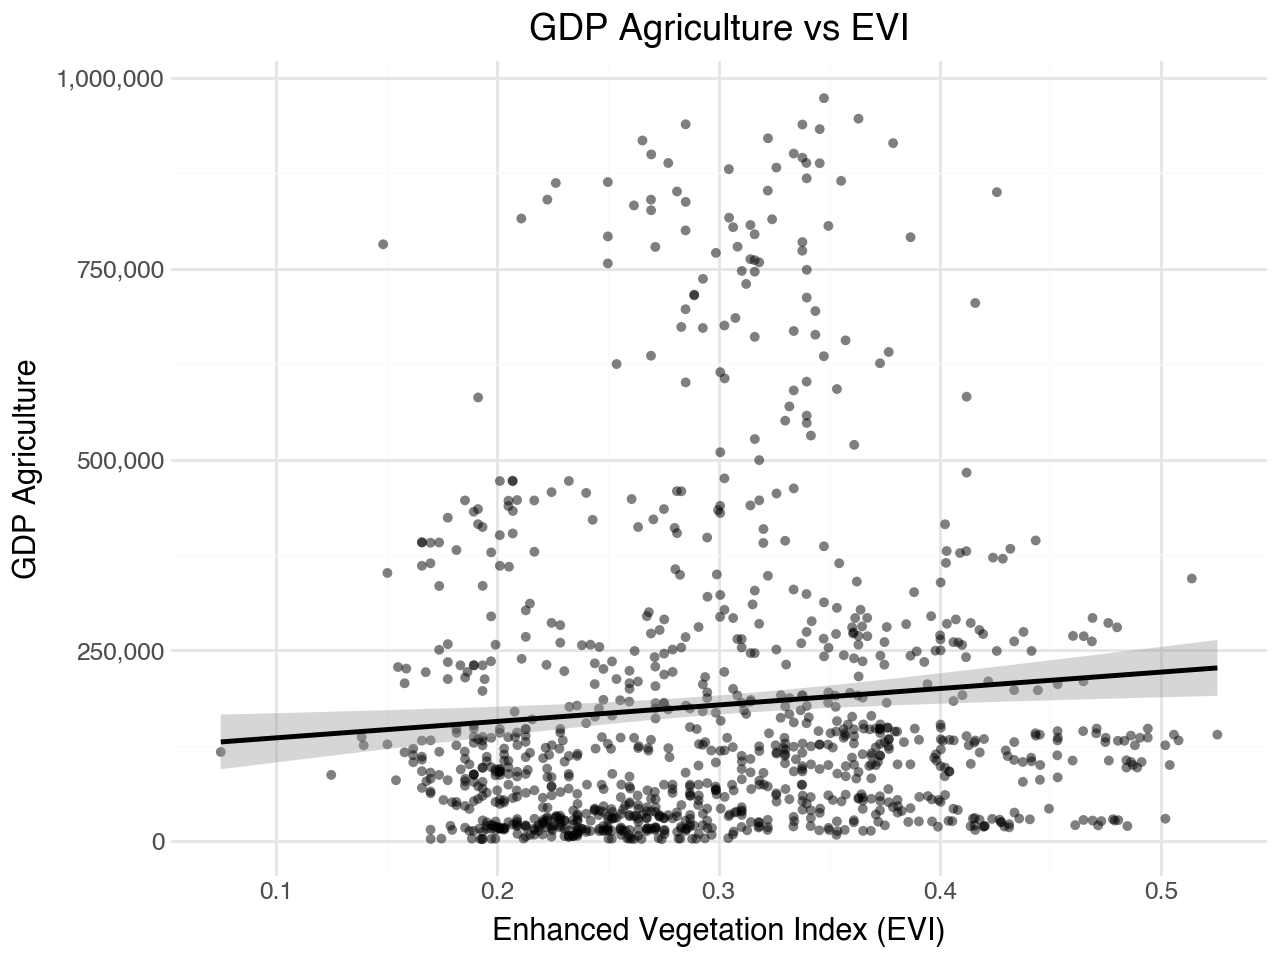

In [36]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

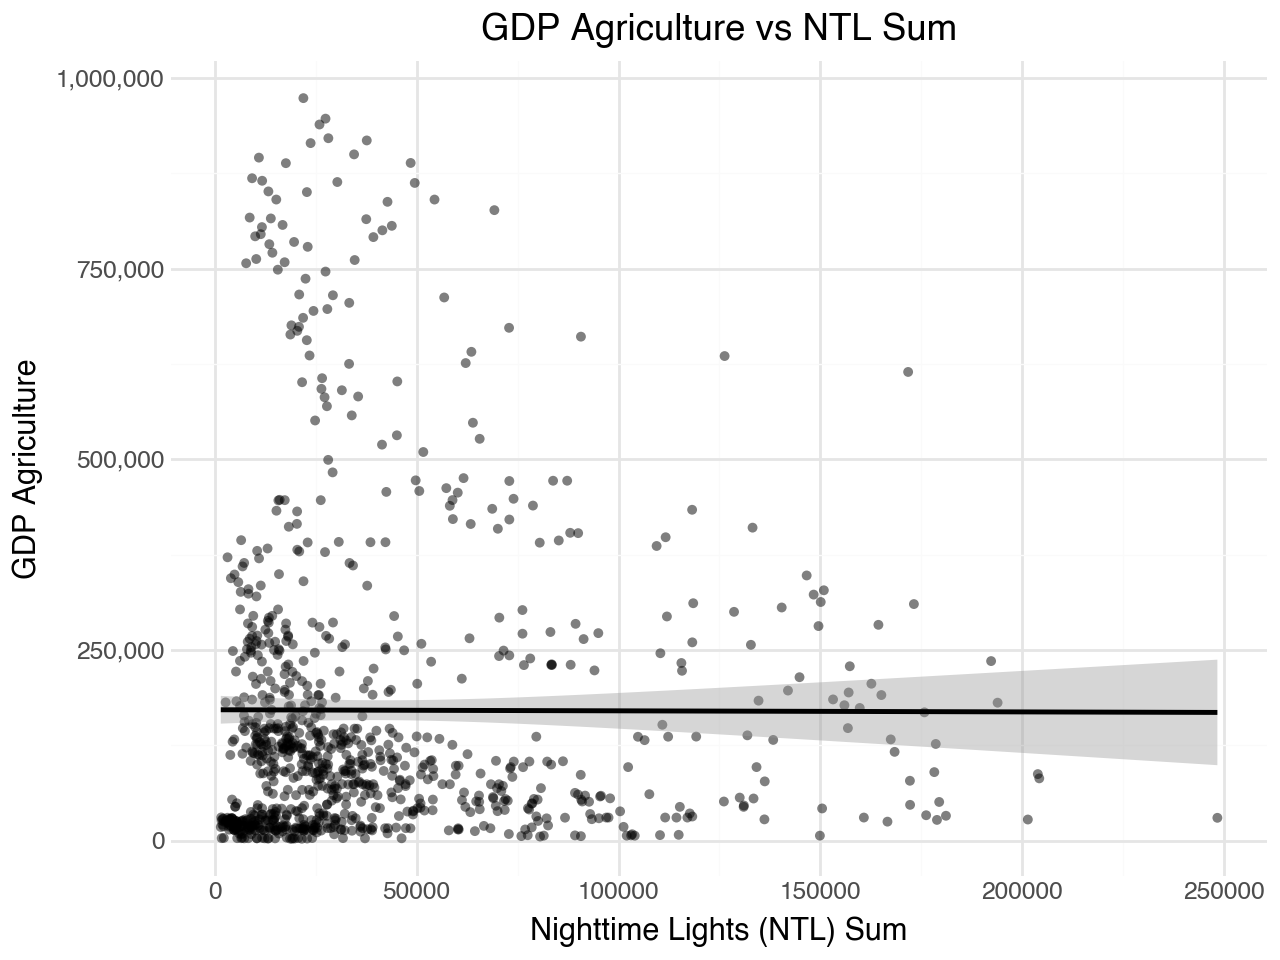

In [37]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Sum",
        x="Nighttime Lights (NTL) Sum",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

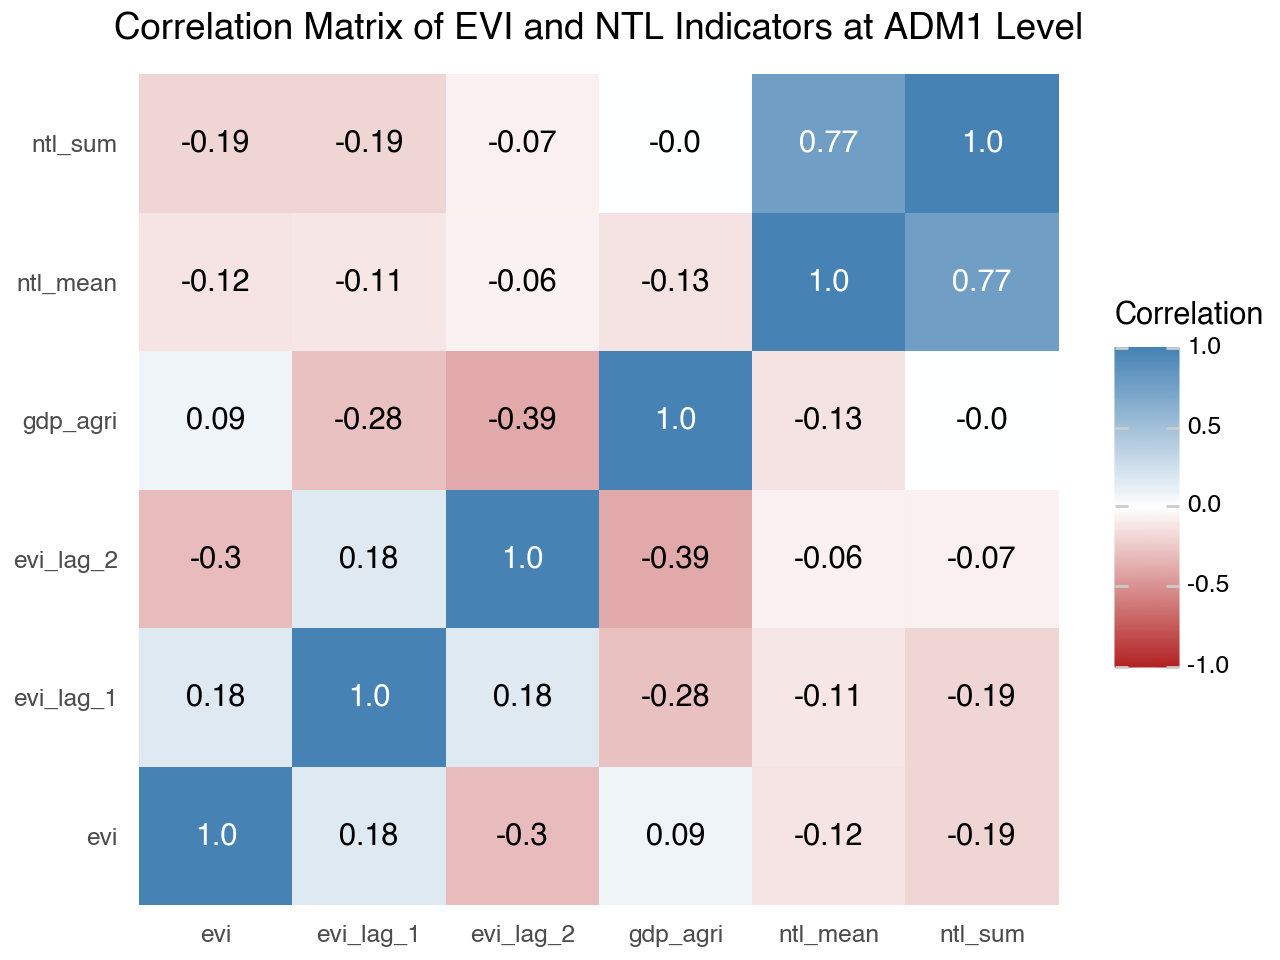

In [38]:
(
    evi_indicators_adm1.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(
        title="Correlation Matrix of EVI and NTL Indicators at ADM1 Level",
        fill="Correlation",
        x="",
        y="",
    )
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

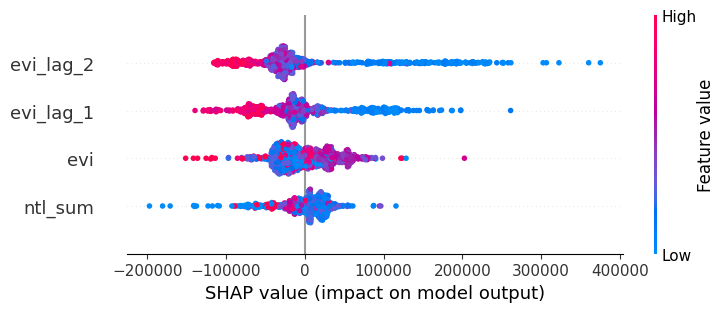

In [39]:
evi_indicators_adm_1_clean = evi_indicators_adm1.dropna()
X = evi_indicators_adm_1_clean[["evi", "ntl_sum", "evi_lag_1", "evi_lag_2"]]
y = evi_indicators_adm_1_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

## NO2

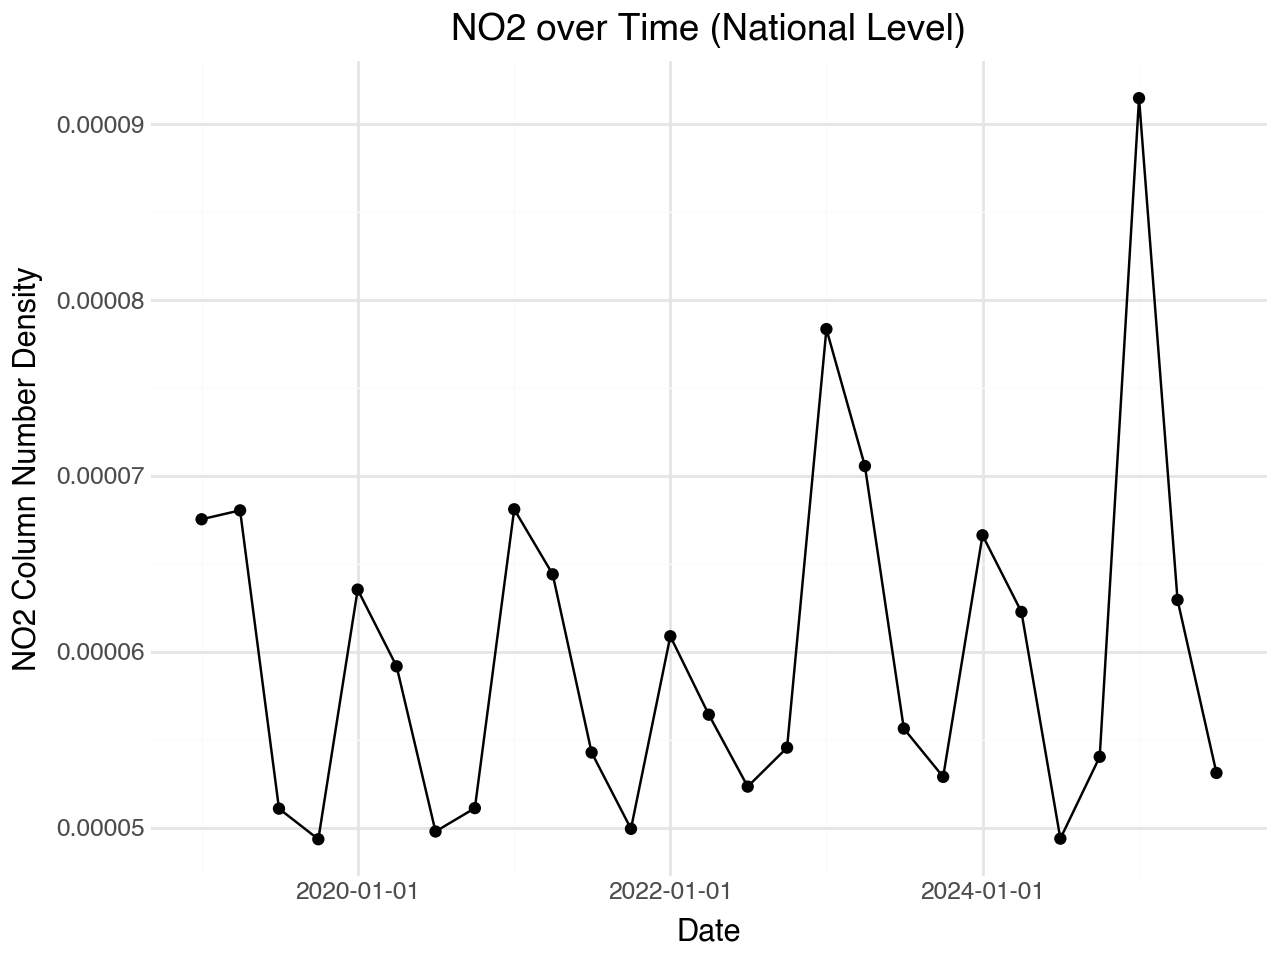

In [40]:
(
    no2_adm0.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="no2")
    + p9.geom_point()
    + p9.geom_line()
    # + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="NO2 over Time (National Level)",
        x="Date",
        y="NO2 Column Number Density",
    )
    + p9.theme_minimal()
)

### Admin Level 0

In [41]:
no2_indicators = (
    gdp_mft_quarterly.join(no2_adm0, how="left")
    .join(gdp_svc_quarterly, how="left")
    .join(ntl_adm0, how="left")
    .assign(
        no2_lag_1=lambda df: df["no2"].shift(1),
        no2_lag_2=lambda df: df["no2"].shift(2),
        ntl_mean_lag_1=lambda df: df["ntl_mean"].shift(1),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
        no2_lag_1_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_1"]]),
        no2_lag_2_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_2"]]),
    )
)
no2_indicators.tail()

gdp_mft       no2       gdp_svc  ntl_mean       ntl_sum  \
date                                                                       
2023-10-01  9.600970e+06  0.000053  8.571614e+06  0.094105  9.450224e+05   
2024-01-01  4.181992e+06  0.000067  5.666039e+06  0.082295  1.102821e+06   
2024-04-01  5.017848e+06  0.000062  6.016582e+06  0.114350  1.085608e+06   
2024-07-01  1.023193e+07  0.000049  1.169164e+07  0.130503  1.217865e+06   
2024-10-01  9.689597e+06  0.000054  8.474285e+06  0.066086  6.640315e+05   

            ntl_sum_lag_1  ntl_sum_lag_2  no2_lag_1  no2_lag_2  \
date                                                             
2023-10-01   1.102821e+06   1.085608e+06   0.000056   0.000071   
2024-01-01   1.085608e+06   1.217865e+06   0.000053   0.000056   
2024-04-01   1.217865e+06   6.640315e+05   0.000067   0.000053   
2024-07-01   6.640315e+05   6.369433e+05   0.000062   0.000067   
2024-10-01   6.369433e+05   1.197890e+06   0.000049   0.000062   

            ntl_mean_lag_1   no2_std  ntl_mean_std  ntl_sum_std  \
date                                                              
2023-10-01        0.118108 -0.739904      0.891204     0.931960   
2024-01-01        0.094105  0.991350      0.384744     1.608715   
2024-04-01        0.082295  0.441926      1.759329     1.534892   
2024-07-01        0.114350 -1.182759      2.452010     2.102106   
2024-10-01        0.130503 -0.596329     -0.310302    -0.273131   

            no2_lag_1_std  no2_lag_2_std  
date                                      
2023-10-01      -0.414237       1.403455  
2024-01-01      -0.755570      -0.473710  
2024-04-01       0.952487      -0.818883  
2024-07-01       0.410425       0.908387  
2024-10-01      -1.192493       0.360228

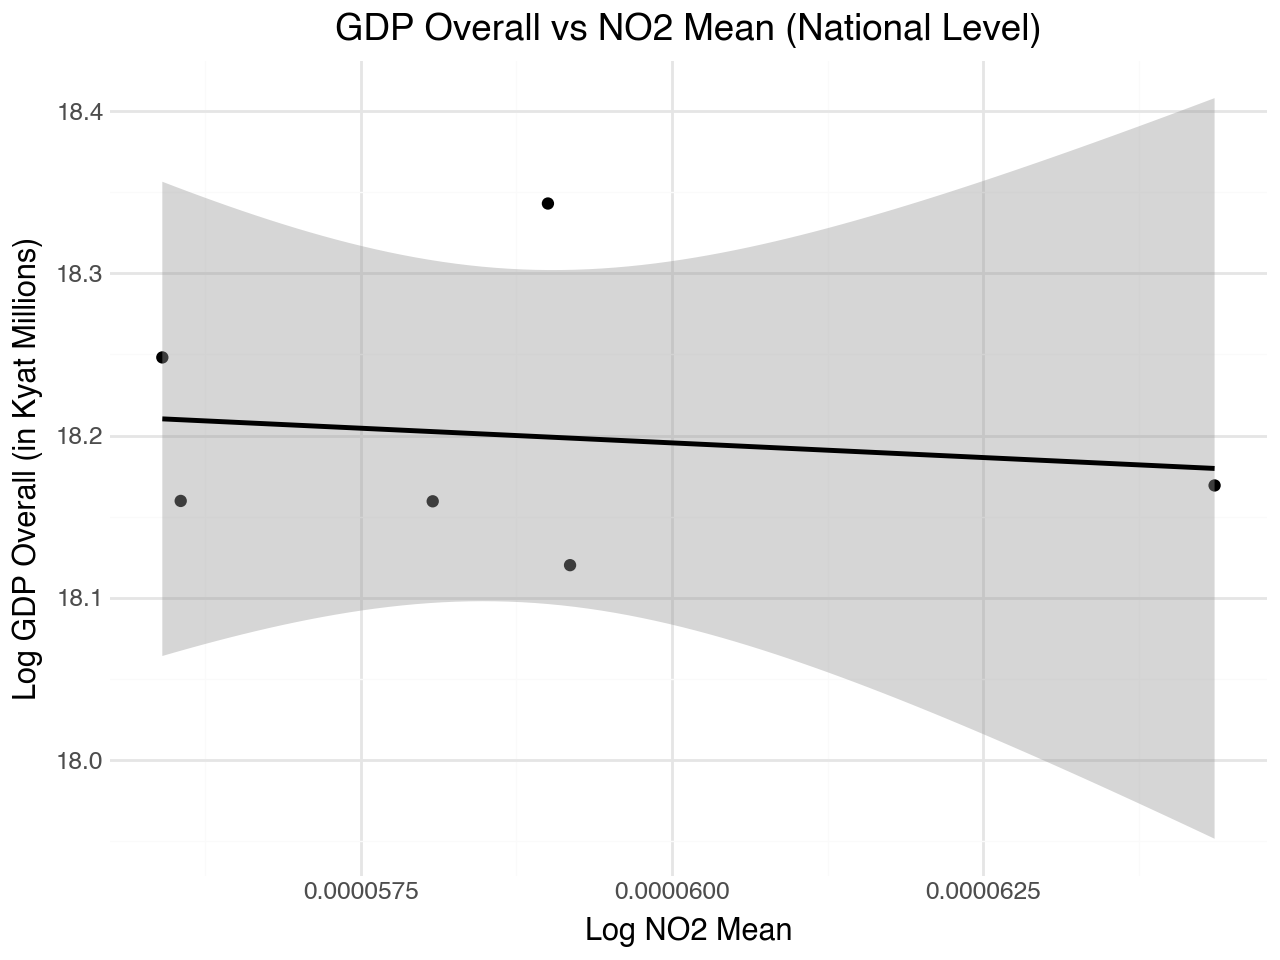

In [42]:
no2_adm0_annual = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="YS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

(
    no2_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        no2_log=lambda df: np.log1p(df["no2"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs NO2 Mean (National Level)",
        x="Log NO2 Mean",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

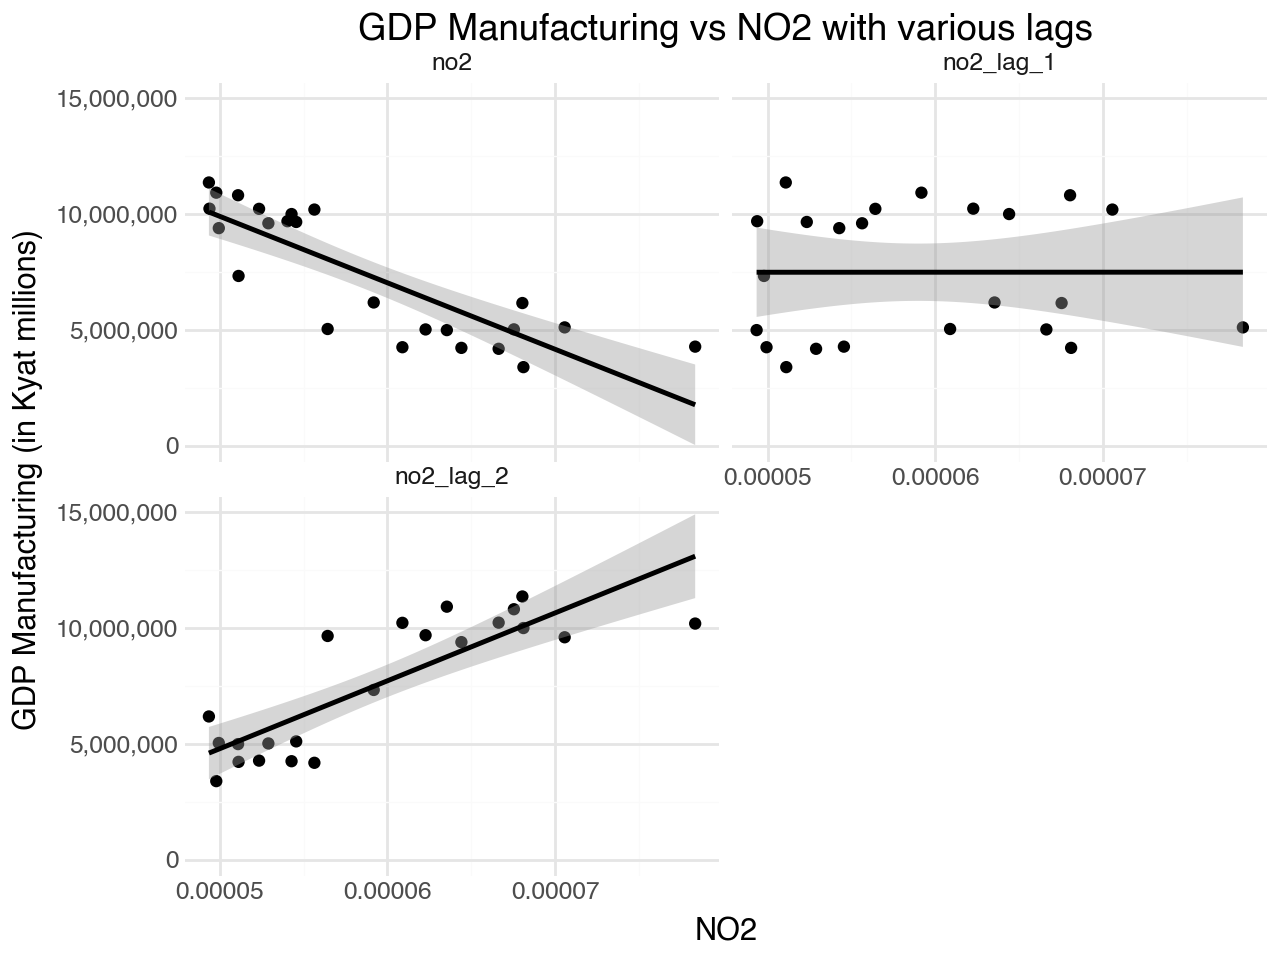

In [43]:
(
    no2_indicators.filter(["gdp_mft", "no2", "no2_lag_1", "no2_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_mft", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Manufacturing vs NO2 with various lags",
        x="NO2",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.theme_minimal()
)

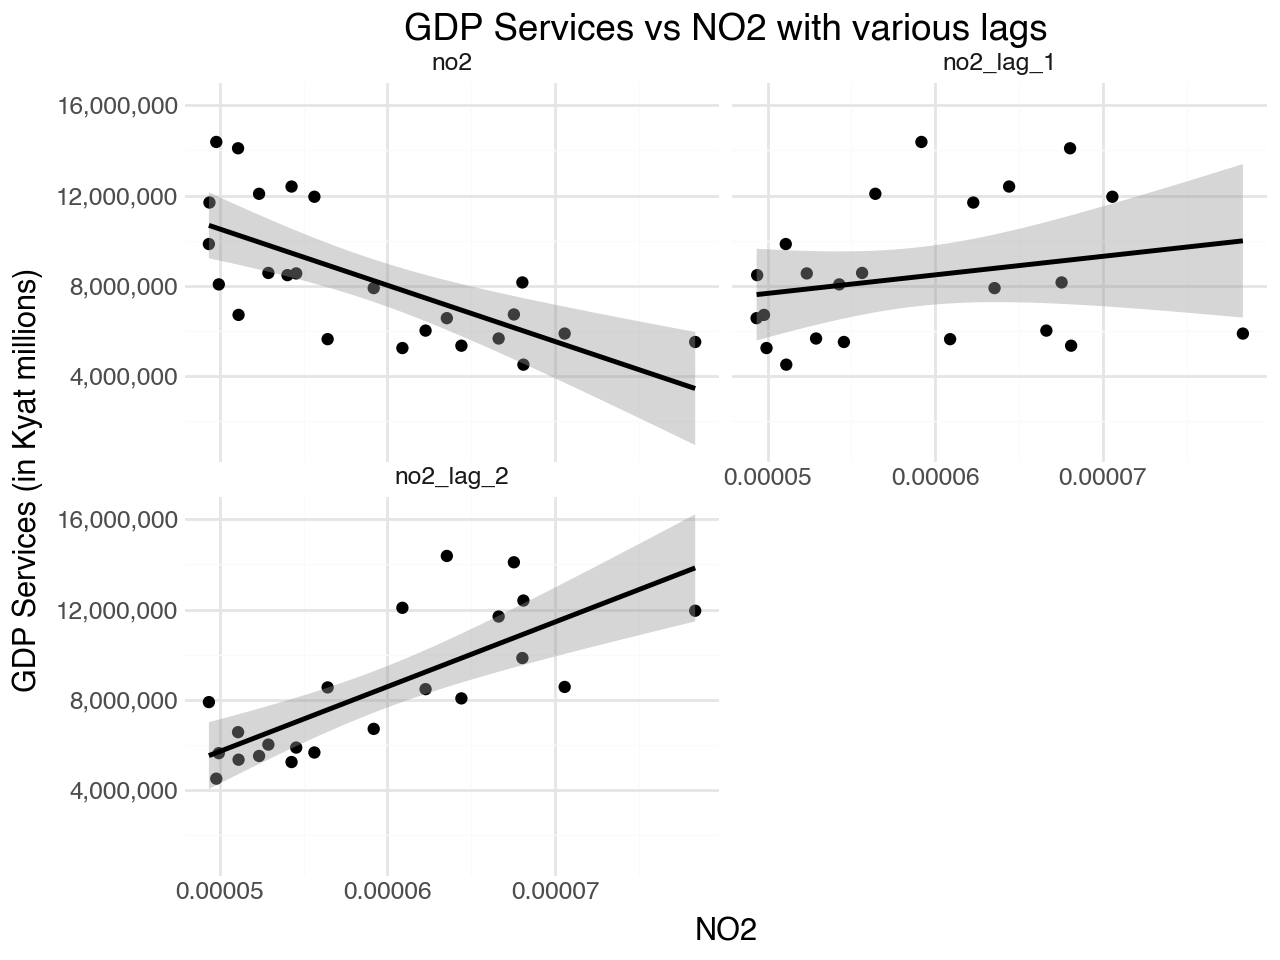

In [44]:
(
    no2_indicators.filter(["gdp_svc", "no2", "no2_lag_1", "no2_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_svc", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_svc")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Services vs NO2 with various lags",
        x="NO2",
        y="GDP Services (in Kyat millions)",
    )
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.theme_minimal()
)

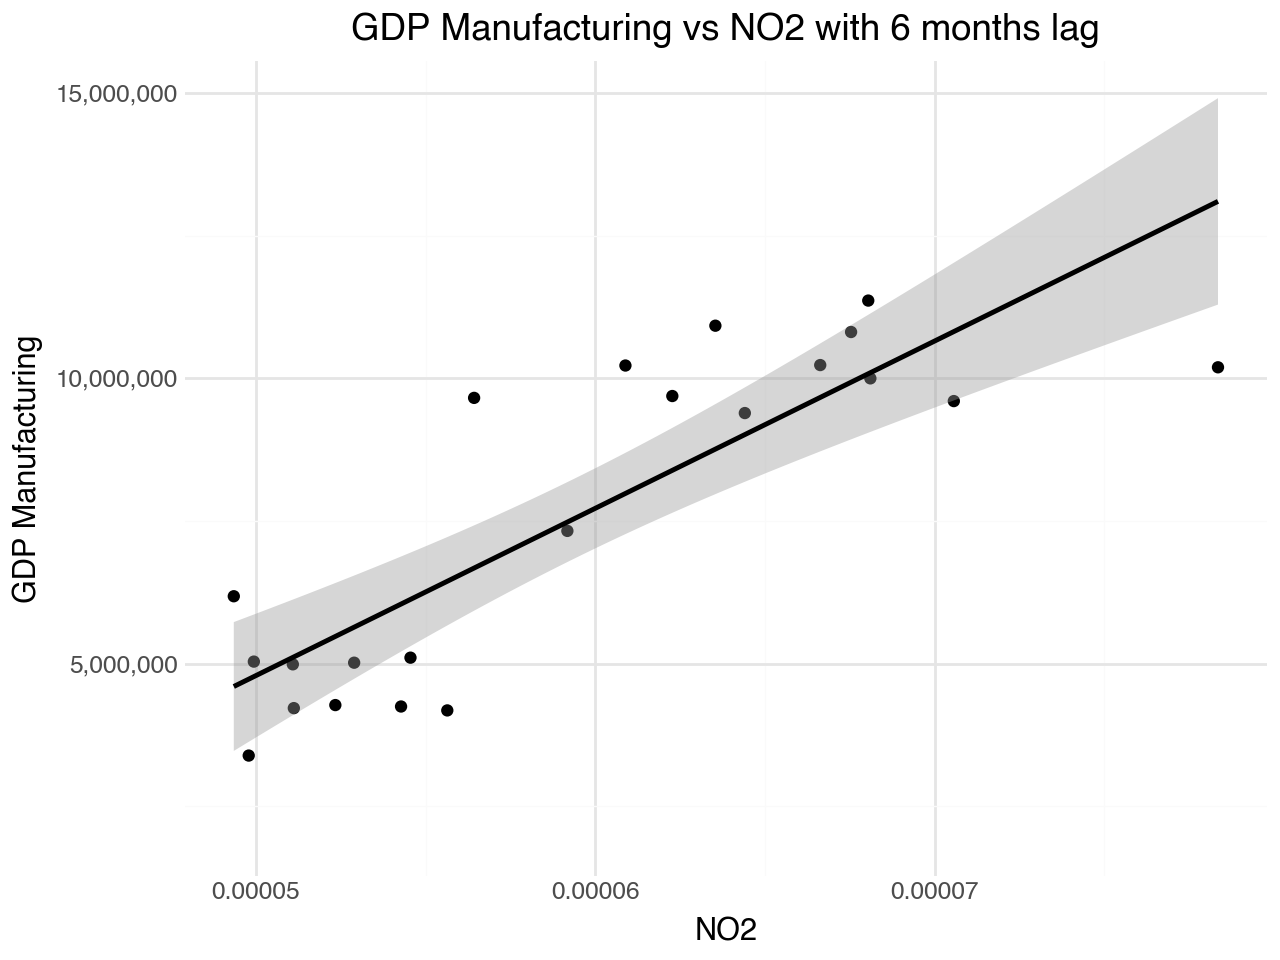

In [45]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_lag_2", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2 with 6 months lag",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

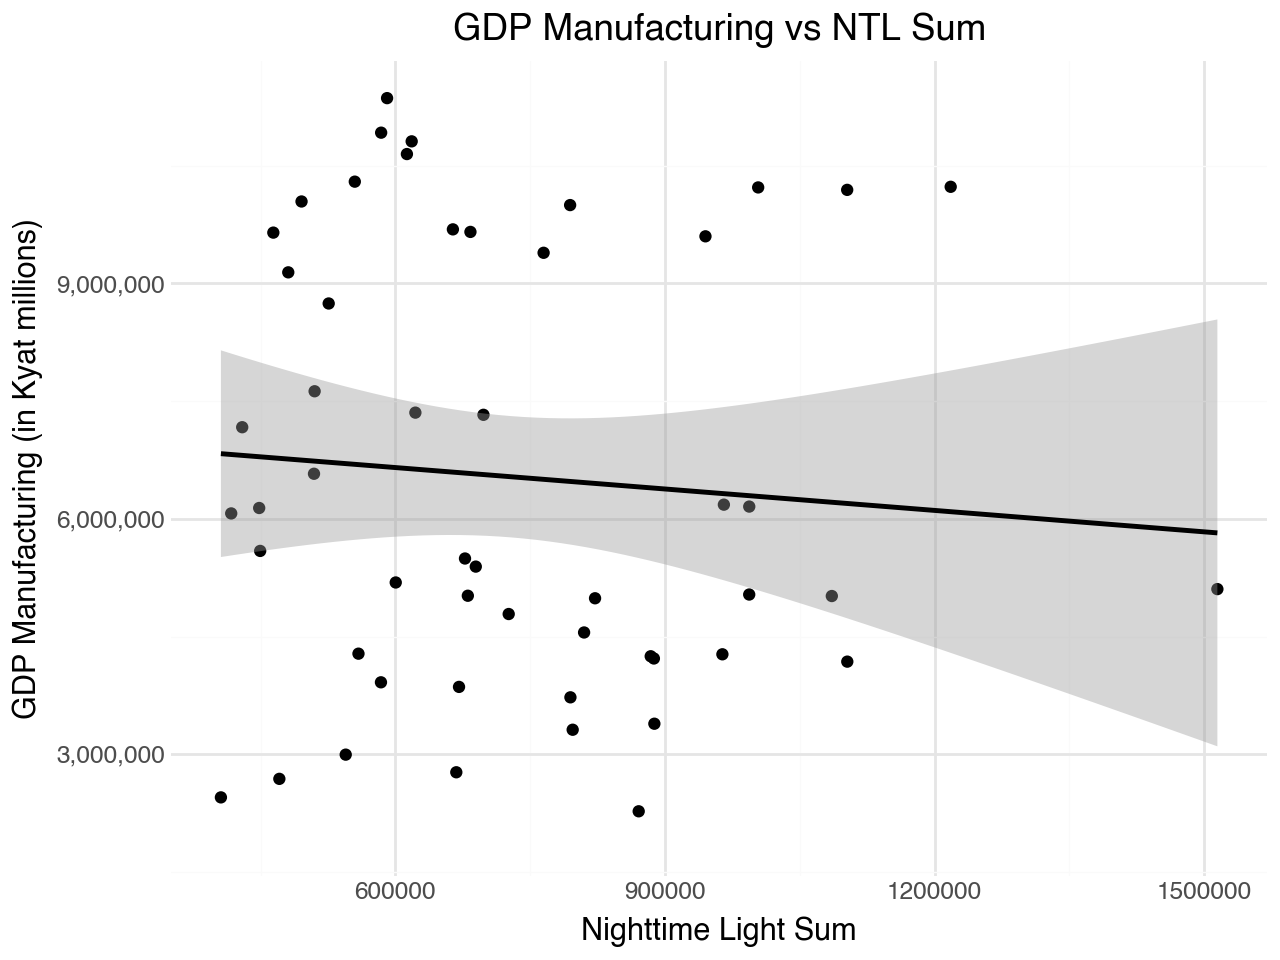

In [46]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.theme_minimal()
)

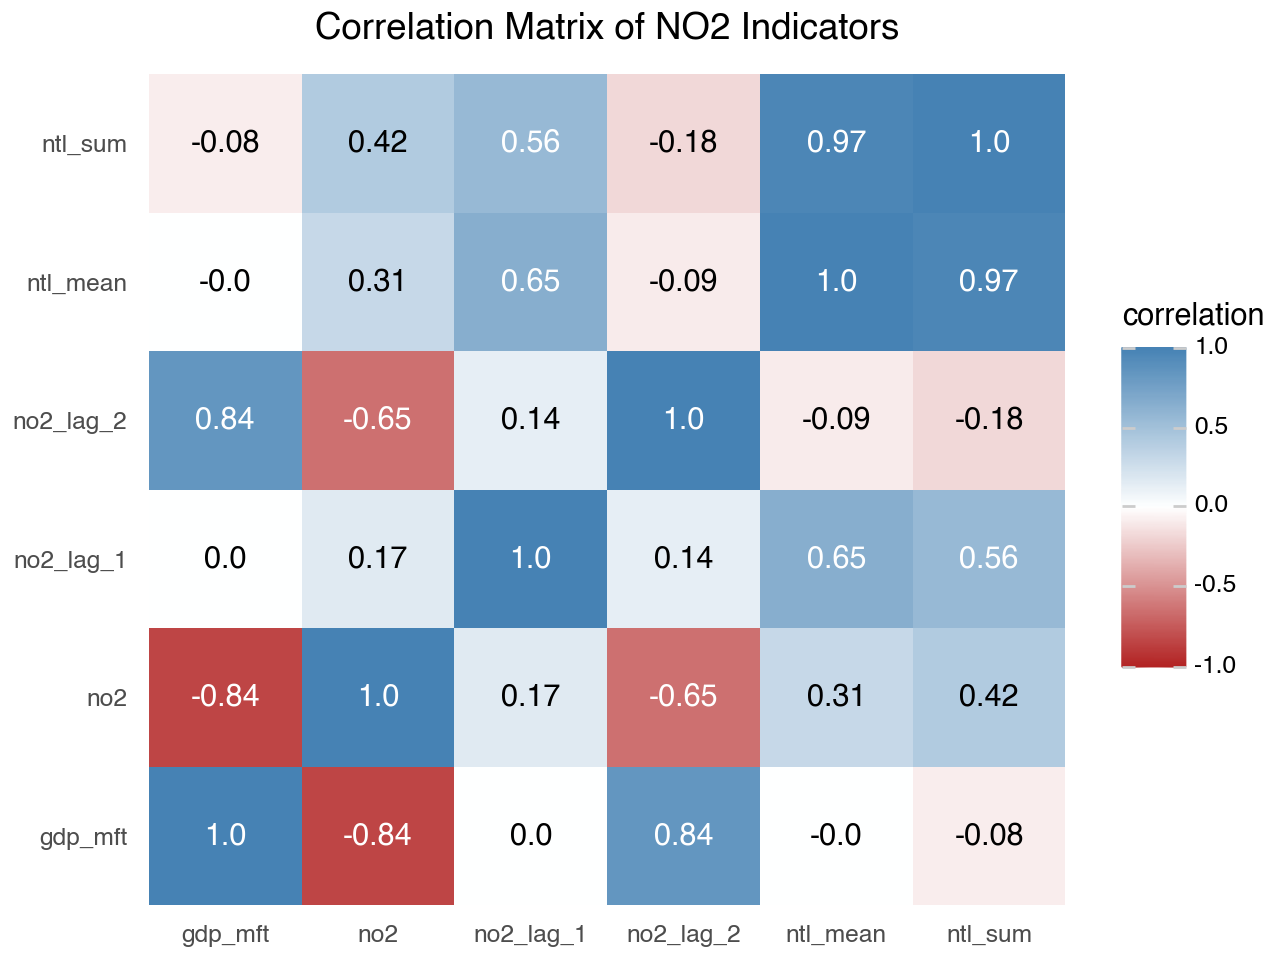

In [47]:
(
    no2_indicators.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of NO2 Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [48]:
mod_1 = smf.ols("gdp_mft ~ no2", data=no2_indicators).fit()
mod_2 = smf.ols("gdp_mft ~ ntl_mean + no2", data=no2_indicators).fit()
mod_3 = smf.ols(
    "gdp_mft ~ ntl_mean + no2 + no2_lag_1 + no2_lag_2", data=no2_indicators
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [49]:
mod_4 = smf.ols(
    "gdp_mft ~ ntl_mean_std + no2_std + no2_lag_1_std + no2_lag_2_std",
    data=no2_indicators,
).fit()

Stargazer([mod_4])

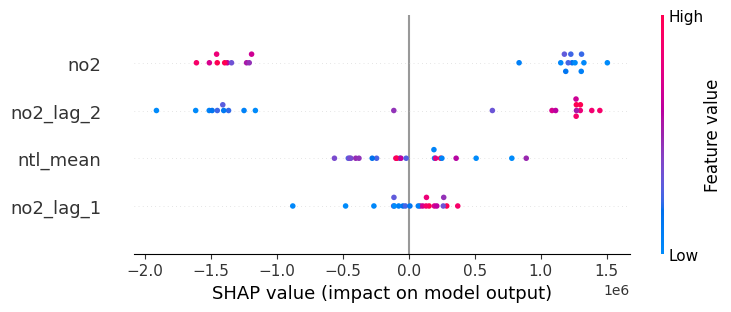

In [50]:
no2_indicators_clean = no2_indicators.dropna()
X = no2_indicators_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### Admin Level 1

In [51]:
no2_indicators_adm1 = (
    gdp_mft_quarterly_adm1.join(no2_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_mft_c=lambda df: df["gdp_mft"] - df["gdp_mft"].mean(),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            no2_lag_1=df["no2"].shift(1),
            no2_lag_2=df["no2"].shift(2),
            no2_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_1"]]
            ),
            no2_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_2"]]
            ),
            ntl_mean_lag_1=df["ntl_mean"].shift(1),
        ),
    )
    .set_index(["adm1_name", "date"])
)

no2_indicators_adm1.tail()

gdp_mft       no2  ntl_mean        ntl_sum  \
adm1_name date                                                          
Yangon    2023-10-01  3.398282e+06  0.000084  1.341484  193872.643026   
          2024-01-01  1.480224e+06  0.000117  1.288833  248295.662349   
          2024-04-01  1.776077e+06  0.000078  1.451145  178197.192109   
          2024-07-01  3.621611e+06  0.000053  1.254324  155936.478288   
          2024-10-01  3.429651e+06  0.000083  1.215892  175752.381717   

                         gdp_mft_c   no2_std  ntl_mean_std  ntl_sum_std  \
adm1_name date                                                            
Yangon    2023-10-01  3.057078e+06  2.632758      4.226818     3.852709   
          2024-01-01  1.139020e+06  5.776550      4.039194     5.219149   
          2024-04-01  1.434873e+06  2.078155      4.617595     3.459133   
          2024-07-01  3.280407e+06 -0.345225      3.916221     2.900216   
          2024-10-01  3.088447e+06  2.531909      3.779268     3.397749   

                      no2_lag_1  no2_lag_2  no2_lag_1_std  no2_lag_2_std  \
adm1_name date                                                             
Yangon    2023-10-01   0.000061   0.000082      -0.842427       0.240989   
          2024-01-01   0.000084   0.000061       0.380219      -0.915259   
          2024-04-01   0.000117   0.000084       2.129763       0.327460   
          2024-07-01   0.000078   0.000117       0.071578       2.105729   
          2024-10-01   0.000053   0.000078      -1.277053       0.013752   

                      ntl_mean_lag_1  
adm1_name date                        
Yangon    2023-10-01        1.371373  
          2024-01-01        1.341484  
          2024-04-01        1.288833  
          2024-07-01        1.451145  
          2024-10-01        1.254324

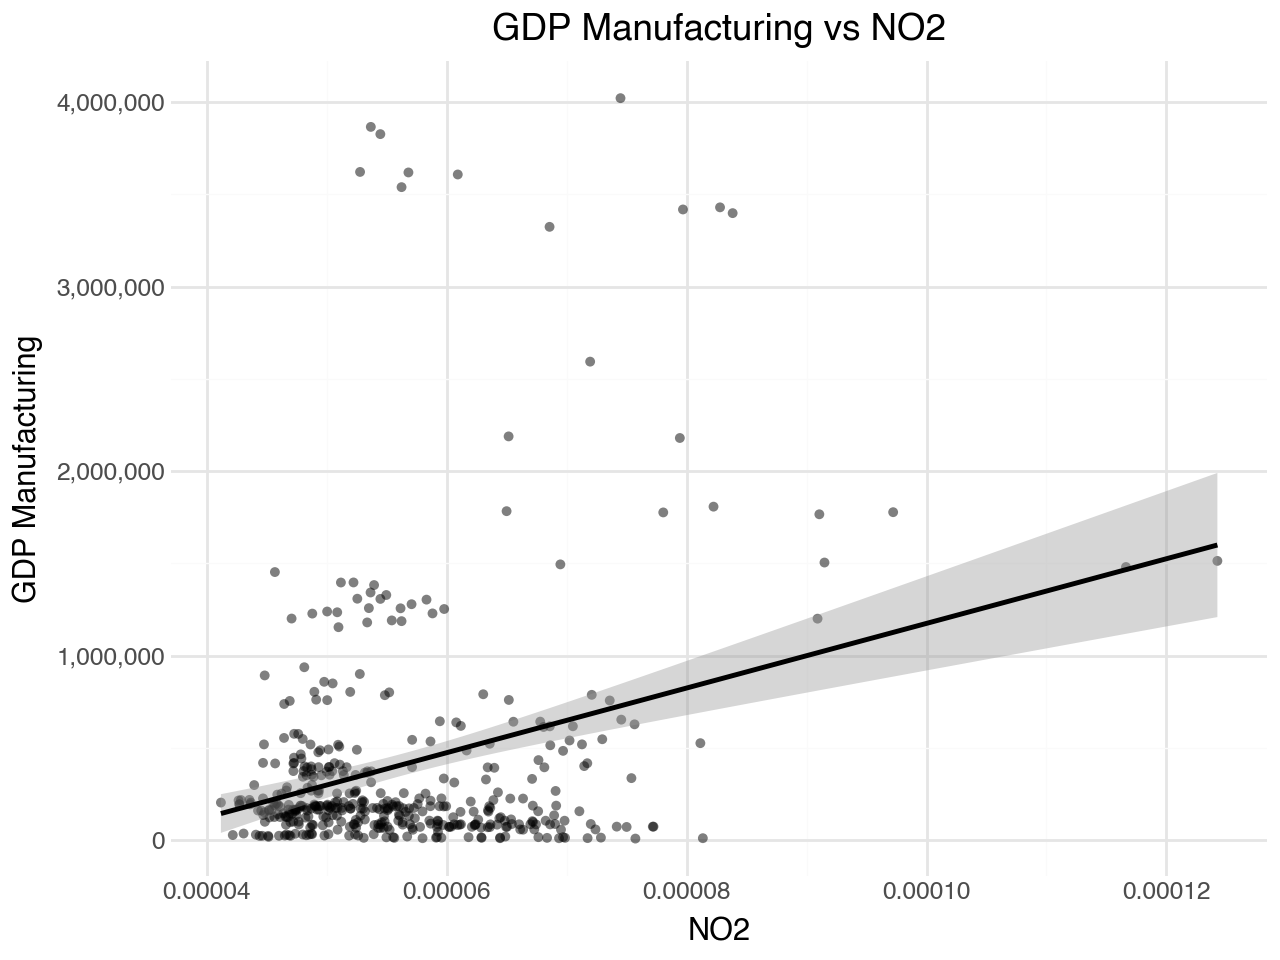

In [52]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

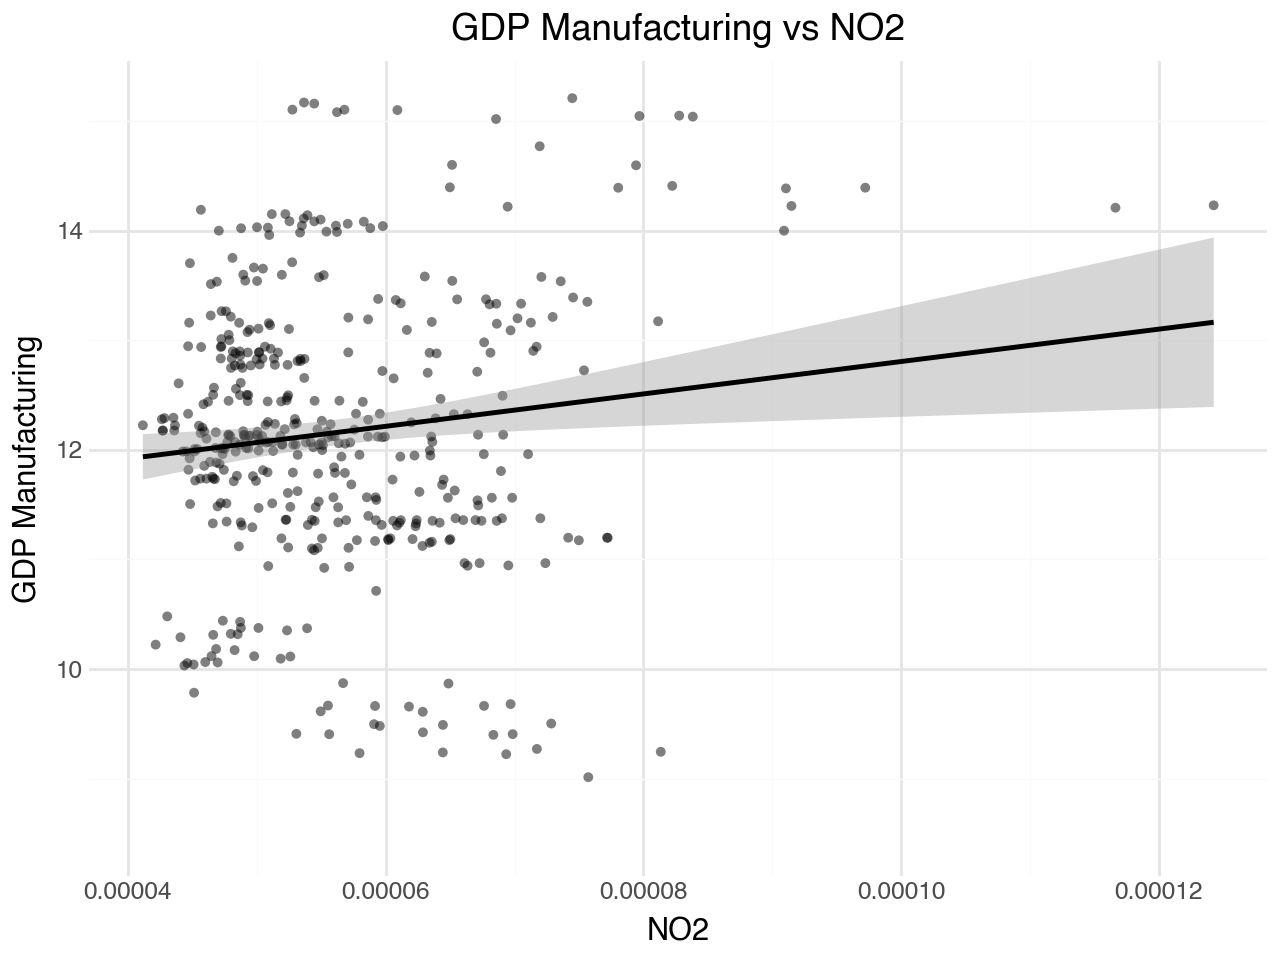

In [53]:
(
    no2_indicators_adm1.assign(
        no2_log=lambda df: np.log1p(df["no2"]),
        gdp_mft_log=lambda df: np.log1p(df["gdp_mft"]),
    ).pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_mft_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Manufacturing vs NO2",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

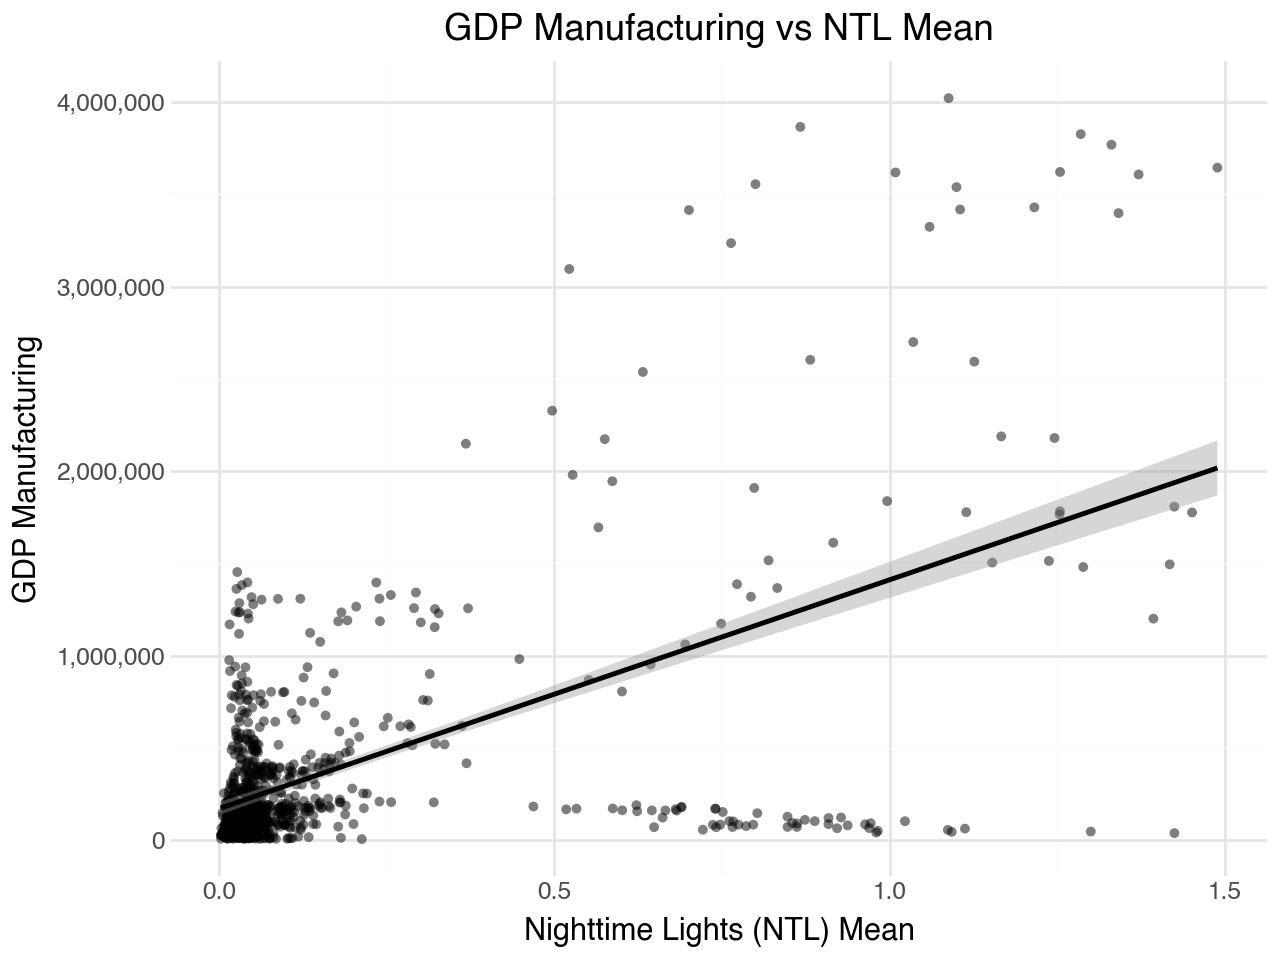

In [54]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_mean", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Mean",
        x="Nighttime Lights (NTL) Mean",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

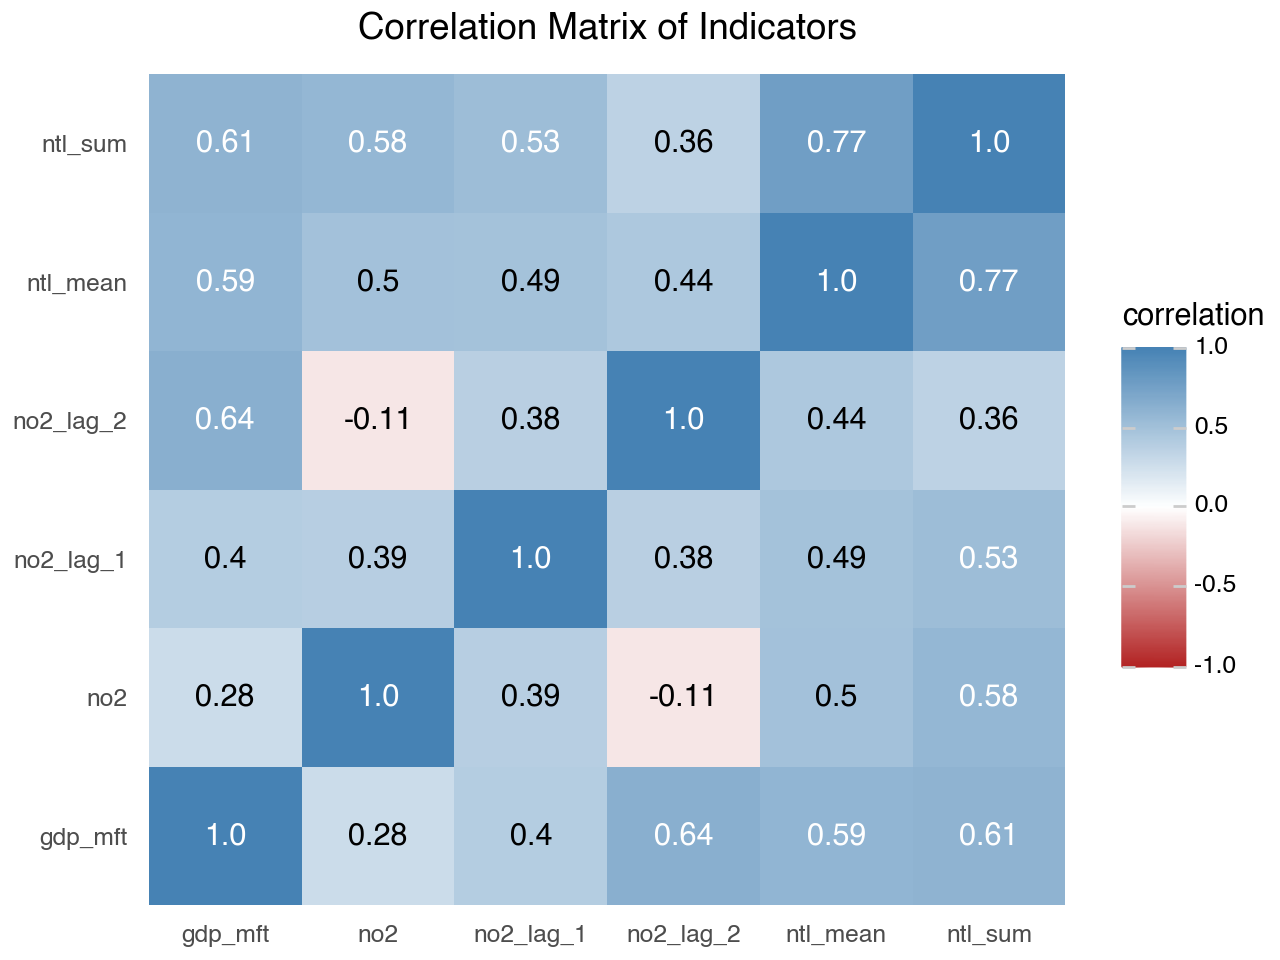

In [55]:
(
    no2_indicators_adm1.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [56]:
mod_3 = smf.ols(
    "np.log(gdp_mft) ~ np.log(ntl_sum) + np.log(no2)",
    data=no2_indicators_adm1,
).fit()

mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(gdp_mft)   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     128.9
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           1.41e-44
Time:                        16:30:00   Log-Likelihood:                -606.79
No. Observations:                 432   AIC:                             1220.
Df Residuals:                     429   BIC:                             1232.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -17.6015      3.636     -4.840      0.000     -24.749     -10.454
np.log(ntl_sum)     0.9857      0.062     15.841      0.000       0.863       1.108
np.log(no2)        -1.9877      0.332     -5.982      0.000      -2.641      -1.335
==============================================================================
Omnibus:                       11.189   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                6.816
Skew:                          -0.136   Prob(JB):                       0.0331
Kurtosis:                       2.449   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
mod_3 = smf.ols(
    "gdp_mft ~ no2",
    data=no2_indicators_adm1,
).fit()

mod_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                gdp_mft   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     36.65
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           3.09e-09
Time:                        16:30:00   Log-Likelihood:                -6378.9
No. Observations:                 432   AIC:                         1.276e+04
Df Residuals:                     430   BIC:                         1.277e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.771e+05   1.66e+05     -3.479      0.001   -9.03e+05   -2.51e+05
no2         1.752e+10   2.89e+09      6.054      0.000    1.18e+10    2.32e+10
==============================================================================
Omnibus:                      323.104   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3758.495
Skew:                           3.247   Prob(JB):                         0.00
Kurtosis:                      15.909   Cond. No.                     9.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

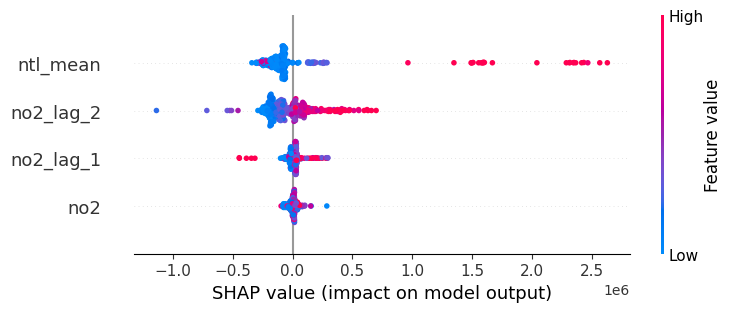

In [58]:
no2_indicators_adm_1_clean = no2_indicators_adm1.dropna()
X = no2_indicators_adm_1_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_adm_1_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)